# Homework2
- Task03：过拟合、欠拟合及其解决方案；梯度消失、梯度爆炸；循环神经网络进阶
- Task04：机器翻译及相关技术；注意力机制与Seq2seq模型；Transformer
- Task05：卷积神经网络基础；leNet；卷积神经网络进阶

# Task03：过拟合、欠拟合及其解决方案；梯度消失、梯度爆炸；循环神经网络进阶
- Part1 过拟合、欠拟合及其解决方案
- Part2 梯度消失、梯度爆炸
- Part3 循环神经网络进阶

# Part1 过拟合、欠拟合及其解决方案
- 模型选择、过拟合、欠拟合
- 多项式函数拟合
- 权重衰减
- 丢弃法

# 模型选择、过拟合和欠拟合

## 训练误差和泛化误差
在解释上述现象之前，我们需要区分训练误差（training error）和泛化误差（generalization error）。通俗来讲，前者指模型在训练数据集上表现出的误差，后者指模型在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似。计算训练误差和泛化误差可以使用之前介绍过的损失函数，例如线性回归用到的平方损失函数和softmax回归用到的交叉熵损失函数。

机器学习模型应关注降低泛化误差。

## 模型选择
### 验证数据集
从严格意义上讲，测试集只能在所有超参数和模型参数选定后使用一次。不可以使用测试数据选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。鉴于此，我们可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。例如，我们可以从给定的训练集中随机选取一小部分作为验证集，而将剩余部分作为真正的训练集。

### K折交叉验证  
由于验证数据集不参与模型训练，当训练数据不够用时，预留大量的验证数据显得太奢侈。一种改善的方法是K折交叉验证（K-fold cross-validation）。在K折交叉验证中，我们把原始训练数据集分割成K个不重合的子数据集，然后我们做K次模型训练和验证。每一次，我们使用一个子数据集验证模型，并使用其他K-1个子数据集来训练模型。在这K次训练和验证中，每次用来验证模型的子数据集都不同。最后，我们对这K次训练误差和验证误差分别求平均。
## 过拟合和欠拟合
接下来，我们将探究模型训练中经常出现的两类典型问题：
- 一类是模型无法得到较低的训练误差，我们将这一现象称作欠拟合（underfitting）；
- 另一类是模型的训练误差远小于它在测试数据集上的误差，我们称该现象为过拟合（overfitting）。
在实践中，我们要尽可能同时应对欠拟合和过拟合。虽然有很多因素可能导致这两种拟合问题，在这里我们重点讨论两个因素：模型复杂度和训练数据集大小。

### 模型复杂度
为了解释模型复杂度，我们以多项式函数拟合为例。给定一个由标量数据特征$x$和对应的标量标签$y$组成的训练数据集，多项式函数拟合的目标是找一个$K$阶多项式函数


$$
 \hat{y} = b + \sum_{k=1}^K x^k w_k 
$$


来近似 $y$。在上式中，$w_k$是模型的权重参数，$b$是偏差参数。与线性回归相同，多项式函数拟合也使用平方损失函数。特别地，一阶多项式函数拟合又叫线性函数拟合。

给定训练数据集，模型复杂度和误差之间的关系：

![Image Name](https://cdn.kesci.com/upload/image/q5jc27wxoj.png?imageView2/0/w/960/h/960)

### 训练数据集大小
影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。一般来说，如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生。此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，例如层数较多的深度学习模型。

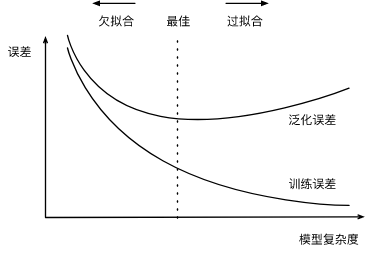

# 多项式函数拟合

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l
print(torch.__version__)

1.3.0


## 初始化模型参数

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [3]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.3218],
         [-0.3237]]), tensor([[-0.3218,  0.1035, -0.0333],
         [-0.3237,  0.1048, -0.0339]]), tensor([4.0676, 4.0544]))

## 定义、训练和测试模型

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    # d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [5]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    # 初始化网络模型
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    # 设置批量大小
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)      # 设置数据集
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True) # 设置获取数据方式
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)                      # 设置优化函数，使用的是随机梯度下降优化
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:                                                 # 取一个批量的数据
            l = loss(net(X), y.view(-1, 1))                                     # 输入到网络中计算输出，并和标签比较求得损失函数
            optimizer.zero_grad()                                               # 梯度清零，防止梯度累加干扰优化
            l.backward()                                                        # 求梯度
            optimizer.step()                                                    # 迭代优化函数，进行参数优化
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())         # 将训练损失保存到train_ls中
        test_ls.append(loss(net(test_features), test_labels).item())            # 将测试损失保存到test_ls中
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

## 三阶多项式函数拟合（正常）

In [6]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 0.00011660061136353761 test loss 0.00017045893764588982
weight: tensor([[ 1.2108, -3.3995,  5.5956]]) 
bias: tensor([4.9996])


<Figure size 432x288 with 1 Axes>

## 线性函数拟合（欠拟合）

In [7]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 44.76585006713867 test loss 118.83914947509766
weight: tensor([[12.1562]]) 
bias: tensor([2.6400])


<Figure size 432x288 with 1 Axes>

## 训练样本不足（过拟合）

In [8]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

final epoch: train loss 0.1520145982503891 test loss 421.29791259765625
weight: tensor([[-1.0457,  0.8831, -0.5873]]) 
bias: tensor([3.2220])


<Figure size 432x288 with 1 Axes>

# 权重衰减
## 方法  
权重衰减等价于 $L_2$ 范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。

##  L2 范数正则化（regularization）
$L_2$范数正则化在模型原损失函数基础上添加$L_2$范数惩罚项，从而得到训练所需要最小化的函数。$L_2$范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积。以线性回归中的线性回归损失函数为例


$$
 \ell(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2 
$$


其中$w_1, w_2$是权重参数，$b$是偏差参数，样本$i$的输入为$x_1^{(i)}, x_2^{(i)}$，标签为$y^{(i)}$，样本数为$n$。将权重参数用向量$\boldsymbol{w} = [w_1, w_2]$表示，带有$L_2$范数惩罚项的新损失函数为


$$
\ell(w_1, w_2, b) + \frac{\lambda}{2n} |\boldsymbol{w}|^2,
$$


其中超参数$\lambda > 0$。当权重参数均为0时，惩罚项最小。当$\lambda$较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近0。当$\lambda$设为0时，惩罚项完全不起作用。上式中$L_2$范数平方$|\boldsymbol{w}|^2$展开后得到$w_1^2 + w_2^2$。
有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将线性回归一节中权重$w_1$和$w_2$的迭代方式更改为


$$
 \begin{aligned} w_1 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_1 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\ w_2 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_2 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right). \end{aligned} 
$$


可见，$L_2$范数正则化令权重$w_1$和$w_2$先自乘小于1的数，再减去不含惩罚项的梯度。因此，$L_2$范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。


## 高维线性回归实验从零开始的实现
下面，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为$p$。对于训练数据集和测试数据集中特征为$x_1, x_2, \ldots, x_p$的任一样本，我们使用如下的线性函数来生成该样本的标签：


$$
 y = 0.05 + \sum_{i = 1}^p 0.01x_i + \epsilon 
$$


其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度$p=200$；同时，我们特意把训练数据集的样本数设低，如20。

In [9]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l

print(torch.__version__)

1.3.0


## 初始化模型参数
与前面观察过拟合和欠拟合现象的时候相似，在这里不再解释。

In [10]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [11]:
# 定义参数初始化函数，初始化模型参数并且附上梯度
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 定义L2范数惩罚项

In [12]:
def l2_penalty(w):
    return (w**2).sum() / 2

## 定义训练和测试

In [13]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

## 观察过拟合

In [14]:
fit_and_plot(lambd=0)

L2 norm of w: 13.82959270477295


<Figure size 252x180 with 1 Axes>

## 使用权重衰减

In [15]:
fit_and_plot(lambd=3)

L2 norm of w: 0.036054737865924835


<Figure size 252x180 with 1 Axes>

## 简洁实现

In [16]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

In [17]:
fit_and_plot_pytorch(0)

L2 norm of w: 12.972947120666504


<Figure size 252x180 with 1 Axes>

In [18]:
fit_and_plot_pytorch(3)

L2 norm of w: 0.04492613300681114


<Figure size 252x180 with 1 Axes>

# 丢弃法

多层感知机中神经网络图描述了一个单隐藏层的多层感知机。其中输入个数为4，隐藏单元个数为5，且隐藏单元$h_i$（$i=1, \ldots, 5$）的计算表达式为


$$
 h_i = \phi\left(x_1 w_{1i} + x_2 w_{2i} + x_3 w_{3i} + x_4 w_{4i} + b_i\right) 
$$


这里$\phi$是激活函数，$x_1, \ldots, x_4$是输入，隐藏单元$i$的权重参数为$w_{1i}, \ldots, w_{4i}$，偏差参数为$b_i$。当对该隐藏层使用丢弃法时，该层的隐藏单元将有一定概率被丢弃掉。设丢弃概率为$p$，那么有$p$的概率$h_i$会被清零，有$1-p$的概率$h_i$会除以$1-p$做拉伸。丢弃概率是丢弃法的超参数。具体来说，设随机变量$\xi_i$为0和1的概率分别为$p$和$1-p$。使用丢弃法时我们计算新的隐藏单元$h_i'$


$$
 h_i' = \frac{\xi_i}{1-p} h_i 
$$


由于$E(\xi_i) = 1-p$，因此


$$
 E(h_i') = \frac{E(\xi_i)}{1-p}h_i = h_i 
$$


即丢弃法不改变其输入的期望值。让我们对之前多层感知机的神经网络中的隐藏层使用丢弃法，一种可能的结果如图所示，其中$h_2$和$h_5$被清零。这时输出值的计算不再依赖$h_2$和$h_5$，在反向传播时，与这两个隐藏单元相关的权重的梯度均为0。由于在训练中隐藏层神经元的丢弃是随机的，即$h_1, \ldots, h_5$都有可能被清零，输出层的计算无法过度依赖$h_1, \ldots, h_5$中的任一个，从而在训练模型时起到正则化的作用，并可以用来应对过拟合。在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法

![Image Name](https://cdn.kesci.com/upload/image/q5jd69in3m.png?imageView2/0/w/960/h/960)

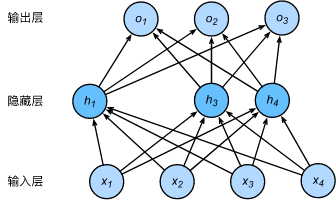

## 丢弃法从零开始的实现

In [19]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l

print(torch.__version__)

1.3.0


In [20]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    
    return mask * X / keep_prob

In [21]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [22]:
dropout(X, 0.5)

tensor([[ 0.,  2.,  4.,  0.,  8., 10., 12., 14.],
        [16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [23]:
dropout(X, 1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
# 参数的初始化
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

In [25]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3

In [26]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() # 改回训练模式
        else: # 自定义的模型
            if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置成False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n

In [27]:
num_epochs, lr, batch_size = 5, 100.0, 256  # 这里的学习率设置的很大，原因与之前相同。
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, root='/home/kesci/input/FashionMNIST2065')
d2l.train_ch3(
    net,
    train_iter,
    test_iter,
    loss,
    num_epochs,
    batch_size,
    params,
    lr)


epoch 1, loss 0.0045, train acc 0.554, test acc 0.735
epoch 2, loss 0.0023, train acc 0.787, test acc 0.802
epoch 3, loss 0.0019, train acc 0.824, test acc 0.806
epoch 4, loss 0.0018, train acc 0.836, test acc 0.852
epoch 5, loss 0.0016, train acc 0.849, test acc 0.831


## 丢弃法pytorch简洁实现

In [28]:
net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [31]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0046, train acc 0.553, test acc 0.736
epoch 2, loss 0.0023, train acc 0.785, test acc 0.803
epoch 3, loss 0.0019, train acc 0.818, test acc 0.756
epoch 4, loss 0.0018, train acc 0.835, test acc 0.829
epoch 5, loss 0.0016, train acc 0.848, test acc 0.851


# 总结

- 验证数据集 vs 训练数据集 vs 测试数据集
验证数据集可以用来调整模型参数，测试数据集不可以用来调整模型参数，如果使用测试数据集调整模型参数，可能在测试数据集上发生一定程度的过拟合，此时将不能用测试误差来近似泛化误差。在数据量不大的情况，`k折交叉验证`（将数据分为k份，每次选择一份用于验证模型，其余的用于训练模型）是一种常用的验证方法

- 欠拟合现象：模型无法达到一个较低的误差
    
- 过拟合现象：训练误差较低但是泛化误差依然较高，二者相差较大

- 过拟合 vs 欠拟合
过拟合是指训练误差达到一个较低的水平，而泛化误差依然较大。
欠拟合是指训练误差和泛化误差都不能达到一个较低的水平。
过拟合还可以使用`权重衰减`和`丢弃法`来缓解，即使在一个比较小的数据集上使用了权重衰减和丢弃法之后也能够达到一个比较好的效果。
L2范数正则化（权重衰减的具体实例）是用来应对过拟合的解决方案。

# 小结练习


- 为什么优化器中只对权重参数设置衰减，而不对偏置参数设置衰减呢？

- L2范数惩罚项通过`惩罚绝对值`较大的参数的方法来应对过拟合的。这里面的惩罚绝对值较大的参数是什么意思？

- 我对过拟合和欠拟合的理解（@同济子豪兄）：
https://www.bilibili.com/video/av86713932?p=2
使用正则化可以防止过拟合，比如Dropout、Batch Normalization等
我对Dropout的理解：https://www.bilibili.com/video/av86713932?p=8
Dropout为什么能防止过拟合：打破神经网络之间的联合依赖适应性、化整为零、有性繁殖、相当于模型集成和数据增强

- 按照最开始的说法，训练集，测试集（用来测试训练成果），验证集（用来训练超参数或者选择模型），但K折交叉验证为什么只有k-1个训练和1个验证，没有测试集？“。在这K次训练和验证中，每次用来验证模型的子数据集都不同。最后，我们对这K次训练误差和验证误差分别求平均。”那么这里的k次训练误差是哪里来的呢？

- K折交叉验证中要使用哪一次训练结果来当最终模型呢？

- 过拟合与欠拟合 vs 数据集的大小和模型复杂度

# Part2 梯度消失、梯度爆炸
- 梯度消失和梯度爆炸
- 影响模型效果的其他因素影响
> **协变量偏移**
**标签偏移**
**概念偏移**
- Kaggle房价预测（实战）

# 梯度消失和梯度爆炸

深度模型有关数值稳定性的典型问题是消失（vanishing）和爆炸（explosion）。

**当神经网络的层数较多时，模型的数值稳定性容易变差。**

假设一个层数为$L$的多层感知机的第$l$层$\boldsymbol{H}^{(l)}$的权重参数为$\boldsymbol{W}^{(l)}$，输出层$\boldsymbol{H}^{(L)}$的权重参数为$\boldsymbol{W}^{(L)}$。为了便于讨论，不考虑偏差参数，且设所有隐藏层的激活函数为恒等映射（identity mapping）$\phi(x) = x$。给定输入$\boldsymbol{X}$，多层感知机的第$l$层的输出$\boldsymbol{H}^{(l)} = \boldsymbol{X} \boldsymbol{W}^{(1)} \boldsymbol{W}^{(2)} \ldots \boldsymbol{W}^{(l)}$。此时，如果层数$l$较大，$\boldsymbol{H}^{(l)}$的计算可能会出现衰减或爆炸。举个例子，假设输入和所有层的权重参数都是标量，如权重参数为0.2和5，多层感知机的第30层输出为输入$\boldsymbol{X}$分别与$0.2^{30} \approx 1 \times 10^{-21}$（消失）和$5^{30} \approx 9 \times 10^{20}$（爆炸）的乘积。当层数较多时，梯度的计算也容易出现消失或爆炸。

# 随机初始化模型参数

在神经网络中，通常需要随机初始化模型参数。下面我们来解释这样做的原因。

回顾多层感知机一节描述的多层感知机。为了方便解释，假设输出层只保留一个输出单元$o_1$（删去$o_2$和$o_3$以及指向它们的箭头），且隐藏层使用相同的激活函数。如果将每个隐藏单元的参数都初始化为相等的值，那么在正向传播时每个隐藏单元将根据相同的输入计算出相同的值，并传递至输出层。在反向传播中，每个隐藏单元的参数梯度值相等。因此，这些参数在使用基于梯度的优化算法迭代后值依然相等。之后的迭代也是如此。在这种情况下，无论隐藏单元有多少，隐藏层本质上只有1个隐藏单元在发挥作用。因此，正如在前面的实验中所做的那样，我们通常将神经网络的模型参数，特别是权重参数，进行随机初始化。



![Image Name](https://cdn.kesci.com/upload/image/q5jg76kloy.png?imageView2/0/w/960/h/960)



###  PyTorch的默认随机初始化

随机初始化模型参数的方法有很多。在线性回归的简洁实现中，我们使用`torch.nn.init.normal_()`使模型`net`的权重参数采用正态分布的随机初始化方式。不过，PyTorch中`nn.Module`的模块参数都采取了较为合理的初始化策略（不同类型的layer具体采样的哪一种初始化方法的可参考[源代码](https://github.com/pytorch/pytorch/tree/master/torch/nn/modules)），因此一般不用我们考虑。


### Xavier随机初始化

还有一种比较常用的随机初始化方法叫作Xavier随机初始化。
假设某全连接层的输入个数为$a$，输出个数为$b$，Xavier随机初始化将使该层中权重参数的每个元素都随机采样于均匀分布


$$
U\left(-\sqrt{\frac{6}{a+b}}, \sqrt{\frac{6}{a+b}}\right).
$$


它的设计主要考虑到，模型参数初始化后，每层输出的方差不该受该层输入个数影响，且每层梯度的方差也不该受该层输出个数影响。

# 考虑环境因素

## 协变量偏移

这里我们假设，虽然输入的分布可能随时间而改变，但是标记函数，即条件分布P（y∣x）不会改变。虽然这个问题容易理解，但在实践中也容易忽视。

想想区分猫和狗的一个例子。我们的训练数据使用的是猫和狗的真实的照片，但是在测试时，我们被要求对猫和狗的卡通图片进行分类。

|cat|cat|dog|dog|
|:---------------:|:---------------:|:---------------:|:---------------:|
|![Image Name](https://cdn.kesci.com/upload/image/q5jg8j72fl.jpg?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jg993za3.jpg?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jg9tqs4s.jpg?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jga6mnsk.jpg?imageView2/0/w/200/h/200)|

测试数据：

|cat|cat|dog|dog|
|:---------------:|:---------------:|:---------------:|:---------------:|
|![Image Name](https://cdn.kesci.com/upload/image/q5jgat5lsd.png?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jgbaoij8.png?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jgbswvbb.png?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jgc5j7zv.png?imageView2/0/w/200/h/200)
|

显然，这不太可能奏效。训练集由照片组成，而测试集只包含卡通。在一个看起来与测试集有着本质不同的数据集上进行训练，而不考虑如何适应新的情况，这是不是一个好主意。不幸的是，这是一个非常常见的陷阱。

统计学家称这种协变量变化是因为问题的根源在于特征分布的变化（即协变量的变化）。数学上，我们可以说P（x）改变了，但P（y∣x）保持不变。尽管它的有用性并不局限于此，当我们认为x导致y时，协变量移位通常是正确的假设。


## 标签偏移

    
当我们认为导致偏移的是标签P（y）上的边缘分布的变化，但类条件分布是不变的P（x∣y）时，就会出现相反的问题。当我们认为y导致x时，标签偏移是一个合理的假设。例如，通常我们希望根据其表现来预测诊断结果。在这种情况下，我们认为诊断引起的表现，即疾病引起的症状。有时标签偏移和协变量移位假设可以同时成立。例如，当真正的标签函数是确定的和不变的，那么协变量偏移将始终保持，包括如果标签偏移也保持。有趣的是，当我们期望标签偏移和协变量偏移保持时，使用来自标签偏移假设的方法通常是有利的。这是因为这些方法倾向于操作看起来像标签的对象，这（在深度学习中）与处理看起来像输入的对象（在深度学习中）相比相对容易一些。

病因（要预测的诊断结果）导致 症状（观察到的结果）。  

训练数据集，数据很少只包含流感p(y)的样本。  

而测试数据集有流感p(y)和流感q(y)，其中不变的是流感症状p(x|y)。


## 概念偏移

另一个相关的问题出现在概念转换中，即标签本身的定义发生变化的情况。这听起来很奇怪，毕竟猫就是猫。的确，猫的定义可能不会改变，但我们能不能对软饮料也这么说呢？事实证明，如果我们周游美国，按地理位置转移数据来源，我们会发现，即使是如图所示的这个简单术语的定义也会发生相当大的概念转变。


![Image Name](https://cdn.kesci.com/upload/image/q5jgd81pl3.png?imageView2/0/w/640/h/640)

$$
美国软饮料名称的概念转变 
$$
如果我们要建立一个机器翻译系统，分布P（y∣x）可能因我们的位置而异。这个问题很难发现。另一个可取之处是P（y∣x）通常只是逐渐变化。


# Kaggle 房价预测（实战）
- 数据的预处理
- 模型的设计
- 超参的选择

作为深度学习基础篇章的总结，我们将对本章内容学以致用。下面，让我们动手实战一个Kaggle比赛：房价预测。本节将提供未经调优的数据的预处理、模型的设计和超参数的选择。我们希望读者通过动手操作、仔细观察实验现象、认真分析实验结果并不断调整方法，得到令自己满意的结果。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.3.0


## 获取和读取数据集

比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击“Data”标签，并下载这些数据集。

我们将通过`pandas`库读入并处理数据。在导入本节需要的包前请确保已安装`pandas`库。
假设解压后的数据位于`/home/kesci/input/houseprices2807/`目录，它包括两个csv文件。下面使用`pandas`读取这两个文件。

In [3]:
test_data = pd.read_csv("/home/kesci/input/houseprices2807/house-prices-advanced-regression-techniques/test.csv")
train_data = pd.read_csv("/home/kesci/input/houseprices2807/house-prices-advanced-regression-techniques/train.csv")

In [4]:
# 训练数据集包括1460个样本、80个特征和1个标签
train_data.shape

(1460, 81)

In [5]:
# 测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来
test_data.shape

(1459, 80)

In [6]:
# 前4个样本的前4个特征以及后2个特征和标签（SalePrice）
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [7]:
# 将所有的训练数据和测试数据的79个特征按样本连结
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 预处理数据
我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为$\mu$，标准差为$\sigma$。那么，我们可以将该特征的每个值先减去$\mu$再除以$\sigma$得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [9]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

通过`values`属性得到Numpy格式的数据，并转成`Tensor`方便后面的训练

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

## 训练模型

In [11]:
loss = torch.nn.MSELoss() # MSELoss 均方误差

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

定义比赛用来评价模型的对数均方根误差。给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots, y_n$，它的定义为

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}.
$$


In [13]:
# 对数均方根误差的实现
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

```
Adam vs 小批量随机梯度下降
Adam优化算法：对学习率不太敏感
```

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证
我们在模型选择、欠拟合和过拟合中介绍了$K$折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第`i`折交叉验证时所需要的训练和验证数据。

In [15]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

在$K$折交叉验证中我们训练$K$次并返回训练和验证的平均误差

In [16]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 模型选择
我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。
有时候你会发现一组参数的训练误差可以达到很低，但是在$K$折交叉验证上的误差可能反而较高。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察$K$折交叉验证上的误差是否也相应降低。

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

fold 0, train rmse 0.240275, valid rmse 0.221708
fold 1, train rmse 0.229394, valid rmse 0.268690
fold 2, train rmse 0.232215, valid rmse 0.238140
fold 3, train rmse 0.237794, valid rmse 0.218482
fold 4, train rmse 0.230983, valid rmse 0.258570
5-fold validation: avg train rmse 0.234132, avg valid rmse 0.241118


<Figure size 252x180 with 1 Axes>

定义训练和预测函数以及设计模型和调节参数

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)
    # sample_submission_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")


对测试数据集进行预测

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

train rmse 0.229515


<Figure size 252x180 with 1 Axes>

# 小结练习
（1）梯度消失 vs 梯度爆炸
在激活函数的选择的地方讲过，在深层网络中尽量避免选择sigmoid和tanh激活函数，原因是这两个激活函数会把元素转换到`[0, 1]`和`[-1, 1]`之间，会加剧梯度消失的现象。

解析：

- 定义：激活函数$h$是一个几乎可微的函数`h : R → R` .

- 常见的`激活函数`有：`sigmoid`；`tanh`；`ReLU`；`LReLU`, `PReLU`, `RReLU`；`ELU（Exponential Linear Units）`；`softplus`；`softsign`,`softmax`等

- [常见的激活函数及其性质比较](https://www.jiqizhixin.com/graph/technologies/1697e627-30e7-48a6-b799-39e2338ffab5)

（2）协变量偏移 vs 标签偏移 vs 概念偏移
如果数据量足够的情况下，确保训练数据集和测试集中的数据取自同一个数据集，可以防止协变量偏移和标签偏移是正确的。如果数据量很少，少到测试集中存在训练集中未包含的标签，就会发生标签偏移。
- 梯度消失的理解（@同济子豪兄）：
https://www.bilibili.com/video/av86713932?p=3
tanh、sigmoid等存在饱和的激活函数会出现梯度消失
在循环神经网络中使用BPTT反向传播算法，也会出现梯度消失或梯度爆炸
https://www.bilibili.com/video/av86713932?p=9

- BP（反向传播）的解释：（@dw-安晟）
将权重沿负梯度方向进行小步长的位移，可以逐渐的使loss函数下降，从而让模型具有好的效果。
反向传播其实就是从终点的loss往回回溯出每一个变量的梯度，从而好进行梯度下降的优化。
我看到梯度下降知识点的视频已放出，可以去学习一下，应该就对反向传播的意义有比较好的理解了。


# Part3 循环神经网络进阶
- GRU
- LSTM
- 深层RNN
- 双向RNN

RNN循环神经网络存在的问题：梯度较容易出现衰减或爆炸（BPTT反向传播），梯度裁剪可以缓解梯度爆炸，但不能解决梯度衰减问题
GRU门控循环神经网络：捕捉时间序列中时间步距离较大的依赖关系  
**RNN**:  


![Image Name](https://cdn.kesci.com/upload/image/q5jjvcykud.png?imageView2/0/w/320/h/320)


$$
H_{t} = ϕ(X_{t}W_{xh} + H_{t-1}W_{hh} + b_{h})
$$
**GRU**:


![Image Name](https://cdn.kesci.com/upload/image/q5jk0q9suq.png?imageView2/0/w/640/h/640)



$$
R_{t} = σ(X_tW_{xr} + H_{t−1}W_{hr} + b_r)\\    
Z_{t} = σ(X_tW_{xz} + H_{t−1}W_{hz} + b_z)\\  
\widetilde{H}_t = tanh(X_tW_{xh} + (R_t ⊙H_{t−1})W_{hh} + b_h)\\
H_t = Z_t⊙H_{t−1} + (1−Z_t)⊙\widetilde{H}_t
$$
• **重置门**有助于捕捉时间序列里短期的依赖关系；  
• **更新门**有助于捕捉时间序列里长期的依赖关系。    
## GRU
- GRU有重置门和更新门，没有遗忘门。重置门有助于捕捉时间序列里短期的依赖关系，更新门有助于捕捉时间序列⾥长期的依赖关系

In [1]:
import os
os.listdir('/home/kesci/input')

import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
import sys
sys.path.append("../input/")
import d2l_jay9460 as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

### 初始化参数

In [3]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():  
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32) #正态分布
        return torch.nn.Parameter(ts, requires_grad=True)
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.nn.Parameter(torch.zeros(num_hiddens, device=device, dtype=torch.float32), requires_grad=True))
     
    W_xz, W_hz, b_z = _three()  # 更新门参数
    W_xr, W_hr, b_r = _three()  # 重置门参数
    W_xh, W_hh, b_h = _three()  # 候选隐藏状态参数
    
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, dtype=torch.float32), requires_grad=True)
    return nn.ParameterList([W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q])

def init_gru_state(batch_size, num_hiddens, device):   #隐藏状态初始化
    return (torch.zeros((batch_size, num_hiddens), device=device), )

will use cpu


### GRU模型

In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, W_xz) + torch.matmul(H, W_hz) + b_z)
        R = torch.sigmoid(torch.matmul(X, W_xr) + torch.matmul(H, W_hr) + b_r)
        H_tilda = torch.tanh(torch.matmul(X, W_xh) + R * torch.matmul(H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

### 训练模型

In [5]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

In [6]:
d2l.train_and_predict_rnn(gru, get_params, init_gru_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

epoch 40, perplexity 151.074860, time 1.26 sec
 - 分开 我想你的让我爱爱女人 坏坏的让我爱爱女人女人 坏坏的让我爱爱女人女人 坏坏的让我爱爱女人女人 坏坏
 - 不分开 我想你的让我爱爱女人女人 坏坏的让我爱爱女人女人 坏坏的让我爱爱女人女人 坏坏的让我爱爱女人女人 
epoch 80, perplexity 32.175123, time 1.28 sec
 - 分开 我想要你的微笑 像像在美不达 让我的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的
 - 不分开 你爱我的爱写 让我的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的
epoch 120, perplexity 4.896328, time 1.28 sec
 - 分开 我想带你的微笑每天 想著你说 你已一起 再来一碗热粥 你在那里 在小村外的溪边河口默默等著我 娘子
 - 不分开 爱过我 一场两步三步四步望著天 看星星 一颗两颗三颗四颗 连成线背著背默默许下心愿 看远方的星如果
epoch 160, perplexity 1.478549, time 1.33 sec
 - 分开 一直好酒 他被它一抽粥 静色蜡烛 温暖了空屋 白色蜡烛 温暖了空屋藤蔓植物 爬满了伯爵的坟墓 古堡
 - 不分开 爱过我一只会痛 有你去没有故有 想要和你飞棒球 想这样没担忧 唱着歌 一直走 我想就这样牵着你的手


### PyTorch简洁实现

In [7]:
num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率
gru_layer = nn.GRU(input_size=vocab_size, hidden_size=num_hiddens)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.016093, time 0.85 sec
 - 分开的黑色幽默 想通 却又再考倒我 说散 你想很久了吧? 我不想拆穿你 当作 是你开的玩笑 想通 却又再
 - 不分开始 担心今天的你过得好不好 整个画面是你 想你想的睡不著 嘴嘟嘟那可爱的模样 还有在你身上香香的味道
epoch 80, perplexity 1.010066, time 0.86 sec
 - 分开的黑色幽默 说散 你想很久了吧? 我的认真败给黑色幽默 走过了很多地方 我来到伊斯坦堡 就像是童话故
 - 不分开始打呼 管家是一只会说法语举止优雅的猪 吸血前会念约翰福音做为弥补 拥有一双蓝色眼睛的凯萨琳公主 专
epoch 120, perplexity 1.008352, time 0.90 sec
 - 分开的黑色幽默 想通 却又再考倒我 说散 你想很久了吧? 我不想拆穿你 当作 是你开的玩笑 想通 却又再
 - 不分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻       所有回忆对着我进攻    
epoch 160, perplexity 3.082501, time 0.90 sec
 - 分开 我有多是晴天 抛物线进球 穿梭时间的画面 我想想我的让我疯狂的可爱女人 从前 一颗心到 一定实现 
 - 不分开始共渡每一想通 爱可不可以造句如果听的见你手 一颗心到 一定中断熟悉 然后在一片荒芜 我有多是晴天 


# LSTM（Long Short Term Memory）

** 长短期记忆（LSTM）**:  
**遗忘门**：控制上一时间步的记忆细胞 
**输入门**：控制当前时间步的输入  
**输出门**：控制从记忆细胞到隐藏状态  
（每个循环单元中的记忆细胞和循环单元的值为LSTM模型中的隐状态，而非参数，并不需要初始化）
**记忆细胞**：一种特殊的隐藏状态的信息的流动  


![Image Name](https://cdn.kesci.com/upload/image/q5jk2bnnej.png?imageView2/0/w/640/h/640)

$$
I_t = σ(X_tW_{xi} + H_{t−1}W_{hi} + b_i) \\
F_t = σ(X_tW_{xf} + H_{t−1}W_{hf} + b_f)\\
O_t = σ(X_tW_{xo} + H_{t−1}W_{ho} + b_o)\\
\widetilde{C}_t = tanh(X_tW_{xc} + H_{t−1}W_{hc} + b_c)\\
C_t = F_t ⊙C_{t−1} + I_t ⊙\widetilde{C}_t\\
H_t = O_t⊙tanh(C_t)
$$


### 初始化参数

In [8]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32)
        return torch.nn.Parameter(ts, requires_grad=True)
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.nn.Parameter(torch.zeros(num_hiddens, device=device, dtype=torch.float32), requires_grad=True))
    
    W_xi, W_hi, b_i = _three()  # 输入门参数
    W_xf, W_hf, b_f = _three()  # 遗忘门参数
    W_xo, W_ho, b_o = _three()  # 输出门参数
    W_xc, W_hc, b_c = _three()  # 候选记忆细胞参数
    
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, dtype=torch.float32), requires_grad=True)
    return nn.ParameterList([W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q])

def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), 
            torch.zeros((batch_size, num_hiddens), device=device))

will use cpu


### LSTM模型

In [9]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, W_xi) + torch.matmul(H, W_hi) + b_i)
        F = torch.sigmoid(torch.matmul(X, W_xf) + torch.matmul(H, W_hf) + b_f)
        O = torch.sigmoid(torch.matmul(X, W_xo) + torch.matmul(H, W_ho) + b_o)
        C_tilda = torch.tanh(torch.matmul(X, W_xc) + torch.matmul(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * C.tanh()
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H, C)

### 训练模型

In [10]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

d2l.train_and_predict_rnn(lstm, get_params, init_lstm_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

epoch 40, perplexity 210.227055, time 1.50 sec
 - 分开 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我
 - 不分开 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我 我不不我
epoch 80, perplexity 67.084115, time 1.52 sec
 - 分开 我想你你的你 我想想你想想 我不要 我不我 我不要 我不要 我不要 我不要 我不要 我不要 我不要
 - 不分开 你想我 你你我 我想要这我 我不要 我不要 我不要 我不要 我不要 我不要 我不要 我不要 我不要
epoch 120, perplexity 15.117320, time 1.47 sec
 - 分开 我想你的话笑笑 像通  又给我 说你了没有牵着 我说去很生活 一你了我不着 我该了我 我该了这节奏
 - 不分开 我有你的爱笑笑像龙卷风 不不开我 别我的让 如果 一壶  有一些空 我的上梦 我的风空 你的风空 
epoch 160, perplexity 3.974053, time 1.45 sec
 - 分开 我想带你的微笑 像少是不不多 除静是乌鸦抢了它的窝 它在灌木丛旁邂逗 一物死了它比谁都难过 印地安
 - 不分开 你在我不不经大怒火 就想开么已你很久 别说躲都说打到听 不要我 说你眼睛看着我 别发抖 快给我抬起


### PyTorch简洁实现

In [11]:
num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率
lstm_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens)
model = d2l.RNNModel(lstm_layer, vocab_size)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.020872, time 1.02 sec
 - 分开始 相思寄红豆无能为力的在人海中漂泊心伤透 娘子她人在江南等我 泪不休 语沉默 娘子她人在江南等我 
 - 不分开 你怎么每天祈祷我的心跳你知道  杵在伊斯坦堡 却只想你和汉堡 我想要你的微笑每天都能看到  我知道
epoch 80, perplexity 1.015200, time 1.02 sec
 - 分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 
 - 不分开 你叫我怎么跟你像 不要再这样打我妈妈 我说的话 你甘会听 不要再这样打我妈妈 难道你手不会痛吗 不
epoch 120, perplexity 1.012637, time 1.00 sec
 - 分开始 家乡的爹娘早已苍老了轮廓 娘子我欠你太多 一壶好酒 再来一碗热粥 配上几斤的牛肉 我说店小二 三
 - 不分开 你怎么面对我 甩开球我满腔的怒火 我想揍你已经很久 别想躲 说你眼睛看着我 别发抖 快给我抬起头 
epoch 160, perplexity 1.011087, time 1.01 sec
 - 分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 
 - 不分开 你不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活 静静悄悄默


# 深度循环神经网络  

![Image Name](https://cdn.kesci.com/upload/image/q5jk3z1hvz.png?imageView2/0/w/320/h/320)


$$
\boldsymbol{H}_t^{(1)} = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh}^{(1)} + \boldsymbol{H}_{t-1}^{(1)} \boldsymbol{W}_{hh}^{(1)} + \boldsymbol{b}_h^{(1)})\\
\boldsymbol{H}_t^{(\ell)} = \phi(\boldsymbol{H}_t^{(\ell-1)} \boldsymbol{W}_{xh}^{(\ell)} + \boldsymbol{H}_{t-1}^{(\ell)} \boldsymbol{W}_{hh}^{(\ell)} + \boldsymbol{b}_h^{(\ell)})\\
\boldsymbol{O}_t = \boldsymbol{H}_t^{(L)} \boldsymbol{W}_{hq} + \boldsymbol{b}_q
$$

In [12]:
num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率

gru_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens,num_layers=2)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.056776, time 1.48 sec
 - 分开 不要了这样打我妈妈 难道你手不会痛吗 不要再这样打我妈妈 难道你手不会痛吗 不要再这样打我妈妈 难
 - 不分开 一场戏 宁愿心碎哭泣 再狠狠忘记 你爱过我的证据 让晶莹的泪滴 闪烁成回忆 伤人的美丽 你的完美主
epoch 80, perplexity 1.040581, time 1.44 sec
 - 分开 游荡在蓝天边 一片云掉落在我面前 捏成你的形状 随风跟著我 一口一口吃掉忧愁 载著你 彷彿载著阳光
 - 不分开 说完样 生透 我不著 爱情来的太快就像龙卷风 离不开暴风圈来不及逃 我不能再想 我不要再想 我不 
epoch 120, perplexity 1.010937, time 1.52 sec
 - 分开 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 脸上汹涌失控 穿梭时间的画面的钟 从反方
 - 不分开 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 脸上汹涌失控 穿梭时间的画面的钟 从反方
epoch 160, perplexity 1.010987, time 1.56 sec
 - 分开 在色悄剧 我对悔努静烟赏你那张我深爱的脸 祭司 神殿 征战 弓箭 是谁的从前 喜欢在人潮中你只属于
 - 不分开  穿过云层 我试著努力向你奔跑 爱才送到 你却已在别人怀抱 就是开不了口让她知道 我一定会呵护著你


### PyTorch简洁实现

```
gru_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens,num_layers=6)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)
```

# 双向循环神经网络 

![Image Name](https://cdn.kesci.com/upload/image/q5j8hmgyrz.png?imageView2/0/w/320/h/320)

$$ 
\begin{aligned} \overrightarrow{\boldsymbol{H}}_t &= \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh}^{(f)} + \overrightarrow{\boldsymbol{H}}_{t-1} \boldsymbol{W}_{hh}^{(f)} + \boldsymbol{b}_h^{(f)})\\
\overleftarrow{\boldsymbol{H}}_t &= \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh}^{(b)} + \overleftarrow{\boldsymbol{H}}_{t+1} \boldsymbol{W}_{hh}^{(b)} + \boldsymbol{b}_h^{(b)}) \end{aligned} $$
$$
\boldsymbol{H}_t=(\overrightarrow{\boldsymbol{H}}_{t}, \overleftarrow{\boldsymbol{H}}_t)
$$
$$
\boldsymbol{O}_t = \boldsymbol{H}_t \boldsymbol{W}_{hq} + \boldsymbol{b}_q
$$

### PyTorch简洁实现

```
num_hiddens=128
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e-2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率

gru_layer = nn.GRU(input_size=vocab_size, hidden_size=num_hiddens,bidirectional=True)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)
```

# 小结练习
**GRU vs LSTM vs DRNN vs BiRNN**

- @小罗同学：循环神经网络基础推荐视频[同济子豪兄的B站视频](https://www.bilibili.com/video/av86713932/?p=9)
推荐学习资料(知乎高赞)：[LSTM知乎高赞文章](https://zhuanlan.zhihu.com/p/32085405）
- GRU与LSTM非常的相似，也是基于门控的RNN，并且相对于LSTM是一种改进，性能和LSTM差不多，但是参数量比LSTM少，看下面这个链接，可以更好的理解。
知乎高赞：https://zhuanlan.zhihu.com/p/32481747

**延伸阅读：**
- [一文搞懂RNN（循环神经网络）基础篇](https://zhuanlan.zhihu.com/p/30844905)
- [Recurrent Neural Networks cheatsheet]()
- [Understanding RNN and LSTM](https://towardsdatascience.com/understanding-rnn-and-lstm-f7cdf6dfc14e)
- [零基础入门深度学习(5) - 循环神经网络](https://zybuluo.com/hanbingtao/note/541458)
- [循环神经网络 – Recurrent Neural Network | RNN](https://easyai.tech/ai-definition/rnn/)

# Task04：机器翻译及相关技术；注意力机制与Seq2seq模型；Transformer
- 机器翻译及相关技术
- 注意力机制与Seq2seq模型
- Transformer

# Part1 机器翻译及相关技术
- 机器翻译和数据集
- Encoder-Decoder
- Sequence to Sequence模型
- Beam Search

## 机器翻译和数据集
**机器翻译（MT）**
- 机器翻译（MT）是利用机器的力量「自动将一种自然语言（源语言）的文本翻译成另一种语言（目标语言）」。机器翻译方法通常可分成三大类：基于规则的机器翻译（RBMT）、统计机器翻译（SMT）和神经机器翻译（NMT）
- 将一段文本从一种语言自动翻译为另一种语言，用神经网络解决这个问题通常称为神经机器翻译（NMT）。 主要特征：输出是单词序列而不是单个单词。 输出序列的长度可能与源序列的长度不同。

In [1]:
import os
os.listdir('/home/kesci/input/')

['d2lzh1981', 'fraeng6506', 'd2l9528', 'FashionMNIST2065']

In [2]:
import sys
sys.path.append('/home/kesci/input/d2l9528/')
import collections
import d2l
import zipfile
from d2l.data.base import Vocab
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch import optim

### 数据预处理
将数据集清洗、转化为神经网络的输入minbatch
- 分词
- 建立词典
- 得到数据生成器
注意：单词转化为词向量是`模型结构`的一部分，`词向量层`一般作为网络的第一层！

In [3]:
with open('/home/kesci/input/fraeng6506/fra.txt', 'r') as f:
      raw_text = f.read()
print(raw_text[0:1000])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)
Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)
Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)
Who?	Qui ?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)
Wow!	Ça alors !	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)
Fire!	Au feu !	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)
Help!	À l'aide !	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)
Jump.	Saute.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #2416938 (Phoenix)
Stop!	Ça suffit !	CC-BY 2.0 (France) Attribution: tato

In [4]:
def preprocess_raw(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    out = ''
    for i, char in enumerate(text.lower()):
        if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
            out += ' '
        out += char
    return out

text = preprocess_raw(raw_text)
print(text[0:1000])

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi .	salut !	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)
hi .	salut .	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #4320462 (gillux)
run !	cours !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906331 (sacredceltic)
run !	courez !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906332 (sacredceltic)
who?	qui ?	cc-by 2 .0 (france) attribution: tatoeba .org #2083030 (ck) & #4366796 (gillux)
wow !	ça alors !	cc-by 2 .0 (france) attribution: tatoeba .org #52027 (zifre) & #374631 (zmoo)
fire !	au feu !	cc-by 2 .0 (france) attribution: tatoeba .org #1829639 (spamster) & #4627939 (sacredceltic)
help !	à l'aide !	cc-by 2 .0 (france) attribution: tatoeba .org #435084 (lukaszpp) & #128430 (sysko)
jump .	saute .	cc-by 2 .0 (france) attribution: tatoeba .org #631038 (shishir) & #2416938 (phoenix)
stop !	ça suffit !	cc-b

字符在计算机里是以编码的形式存在，我们通常所用的空格是 \x20 ，是在标准ASCII可见字符 0x20~0x7e 范围内。
而 \xa0 属于 latin1 （ISO/IEC_8859-1）中的扩展字符集字符，代表不间断空白符nbsp(non-breaking space)，超出gbk编码范围，是需要去除的特殊字符。在数据预处理的过程中，我们首先需要对数据进行清洗。

### 分词
字符串---单词组成的列表

In [5]:
num_examples = 50000
source, target = [], []
for i, line in enumerate(text.split('\n')):
    if i > num_examples:
        break
    parts = line.split('\t')
    if len(parts) >= 2:
        source.append(parts[0].split(' '))
        target.append(parts[1].split(' '))
        
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

In [6]:
d2l.set_figsize()
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]],label=['source', 'target'])
d2l.plt.legend(loc='upper right');

<Figure size 252x180 with 1 Axes>

### 建立词典
单词组成的列表---单词id组成的列表

In [7]:
def build_vocab(tokens):
    tokens = [token for line in tokens for token in line]
    return d2l.data.base.Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

3789

### 载入数据集

In [8]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))
pad(src_vocab[source[0]], 10, src_vocab.pad)

[38, 4, 0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
def build_array(lines, vocab, max_len, is_source):
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(1) #第一个维度
    return array, valid_len

In [10]:
def load_data_nmt(batch_size, max_len): # This function is saved in d2l.
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_data = data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [11]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len, Y, Y_valid_len, in train_iter:
    print('X =', X.type(torch.int32), '\nValid lengths for X =', X_valid_len,
        '\nY =', Y.type(torch.int32), '\nValid lengths for Y =', Y_valid_len)
    break

X = tensor([[   5,   78,   20,  498,    4,    0,    0,    0],
        [1077,   26,  299,    4,    0,    0,    0,    0]], dtype=torch.int32) 
Valid lengths for X = tensor([5, 4]) 
Y = tensor([[   1,    5,  100,   22,   25, 1811,    4,    2],
        [   1,    3,  190,  294,    4,    2,    0,    0]], dtype=torch.int32) 
Valid lengths for Y = tensor([8, 6])


### Encoder-Decoder
 encoder：输入到隐藏状态  
 decoder：隐藏状态到输出


![Image Name](https://cdn.kesci.com/upload/image/q5jcat3c8m.png?imageView2/0/w/640/h/640)



In [12]:
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [13]:
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# Sequence to Sequence模型

### 模型：
训练  
![Image Name](https://cdn.kesci.com/upload/image/q5jc7a53pt.png?imageView2/0/w/640/h/640)
预测

![Image Name](https://cdn.kesci.com/upload/image/q5jcecxcba.png?imageView2/0/w/640/h/640)



### 具体结构：
![Image Name](https://cdn.kesci.com/upload/image/q5jccjhkii.png?imageView2/0/w/500/h/500)
### Encoder

In [15]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.num_hiddens=num_hiddens
        self.num_layers=num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
   
    def begin_state(self, batch_size, device):
        return [torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens),  device=device),
                torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens),  device=device)]
    def forward(self, X, *args):
        X = self.embedding(X) # X shape: (batch_size, seq_len, embed_size)
        X = X.transpose(0, 1)  # RNN needs first axes to be time
        # state = self.begin_state(X.shape[1], device=X.device)
        out, state = self.rnn(X)
        # The shape of out is (seq_len, batch_size, num_hiddens).
        # state contains the hidden state and the memory cell
        # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
        return out, state

In [16]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7),dtype=torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

# Decoder

In [17]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).transpose(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation.
        out = self.dense(out).transpose(0, 1)
        return out, state

In [18]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

### 损失函数

In [19]:
def SequenceMask(X, X_len,value=0):
    maxlen = X.size(1)
    mask = torch.arange(maxlen)[None, :].to(X_len.device) < X_len[:, None]   
    X[~mask]=value
    return X

In [20]:
X = torch.tensor([[1,2,3], [4,5,6]])
SequenceMask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [21]:
X = torch.ones((2,3, 4))
SequenceMask(X, torch.tensor([1,2]),value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [22]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_length shape: (batch_size, )
    def forward(self, pred, label, valid_length):
        # the sample weights shape should be (batch_size, seq_len)
        weights = torch.ones_like(label)
        weights = SequenceMask(weights, valid_length).float()
        self.reduction='none'
        output=super(MaskedSoftmaxCELoss, self).forward(pred.transpose(1,2), label)
        return (output*weights).mean(dim=1)

In [23]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones((3, 4, 10)), torch.ones((3,4),dtype=torch.long), torch.tensor([4,3,0]))

tensor([2.3026, 1.7269, 0.0000])

### 训练

In [24]:
def train_ch7(model, data_iter, lr, num_epochs, device):  # Saved in d2l
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:,:-1], Y[:,1:], Y_vlen-1
            
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen).sum()
            l.backward()

            with torch.no_grad():
                d2l.grad_clipping_nn(model, 5, device)
            num_tokens = Y_vlen.sum().item()
            optimizer.step()
            l_sum += l.sum().item()
            num_tokens_sum += num_tokens
        if epoch % 50 == 0:
            print("epoch {0:4d},loss {1:.3f}, time {2:.1f} sec".format( 
                  epoch, (l_sum/num_tokens_sum), time.time()-tic))
            tic = time.time()

In [25]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_examples, max_len = 64, 1e3, 10
lr, num_epochs, ctx = 0.005, 300, d2l.try_gpu()
src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(
    batch_size, max_len,num_examples)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_ch7(model, train_iter, lr, num_epochs, ctx)

epoch   50,loss 0.111, time 27.6 sec
epoch  100,loss 0.053, time 27.4 sec
epoch  150,loss 0.033, time 27.2 sec
epoch  200,loss 0.028, time 27.7 sec
epoch  250,loss 0.025, time 28.1 sec
epoch  300,loss 0.028, time 27.7 sec


### 测试

In [26]:
def translate_ch7(model, src_sentence, src_vocab, tgt_vocab, max_len, device):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.tensor(src_tokens, device=device)
    enc_valid_length = torch.tensor([src_len], device=device)
    # use expand_dim to add the batch_size dimension.
    enc_outputs = model.encoder(enc_X.unsqueeze(dim=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.tensor([tgt_vocab.bos], device=device).unsqueeze(dim=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input.
        dec_X = Y.argmax(dim=2)
        py = dec_X.squeeze(dim=0).int().item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [27]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate_ch7(
        model, sentence, src_vocab, tgt_vocab, max_len, ctx))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !


# Beam Search
简单贪心搜索（greedy search）：

![Image Name](https://cdn.kesci.com/upload/image/q5jchqoppn.png?imageView2/0/w/440/h/440)

维特比算法：选择整体分数最高的句子（搜索空间太大）
集束搜索：

![Image Name](https://cdn.kesci.com/upload/image/q5jcia86z1.png?imageView2/0/w/640/h/640)


# 小结练习

**延伸阅读**
- [一文看懂 NLP 里的模型框架 Encoder-Decoder 和 Seq2Seq](https://segmentfault.com/a/1190000020843265)
- [神奇的神经机器翻译：从发展脉络到未来前景（附论文资源）](https://www.jiqizhixin.com/articles/2017-08-22-6)




# Part2 注意力机制与Seq2seq模型
- 注意力机制的概念和框架
- 点积注意力机制和多层感知机注意力机制的实现
- 使用注意力机制的seq2seq模型

# 注意力机制
我们可以粗略地把神经注意机制类比成一个可以专注于输入内容的某一子集（或特征）的神经网络. 注意力机制最早是由 DeepMind 为图像分类提出的，这让「神经网络在执行预测任务时可以更多关注输入中的相关部分，更少关注不相关的部分」。当解码器生成一个用于构成目标句子的词时，源句子中仅有少部分是相关的；因此，可以应用一个基于内容的注意力机制来根据源句子动态地生成一个（加权的）语境向量（context vector）, 然后网络会根据这个语境向量而不是某个固定长度的向量来预测词。
在“编码器—解码器（seq2seq）”一节中，解码器在各个时间步依赖相同的背景变量（context vector）来获取输出序列信息。当编码器为循环神经网络时，背景变量来表示它最终时间步的隐藏状态。将源序列输入信息以循环单位状态编码，然后将其传递给解码器以生成目标序列。然而这种结构存在着问题，尤其是RNN机制实际中存在长程梯度消失的问题，对于较长的句子，我们很难寄希望于将输入的序列转化为定长的向量而保存所有的有效信息，所以随着所需翻译句子的长度的增加，这种结构的效果会显著下降。
与此同时，解码的目标词语可能只与原输入的部分词语有关，而并不是与所有的输入有关。例如，当把“Hello world”翻译成“Bonjour le monde”时，“Hello”映射成“Bonjour”，“world”映射成“monde”。在seq2seq模型中，解码器只能隐式地从编码器的最终状态中选择相应的信息。然而，注意力机制可以将这种选择过程显式地建模。

![Image Name](https://cdn.kesci.com/upload/image/q5km4dwgf9.PNG?imageView2/0/w/960/h/960)

## 注意力机制框架

Attention 是一种通用的带权池化方法，输入由两部分构成：询问（query）和键值对（key-value pairs）。$𝐤_𝑖∈ℝ^{𝑑_𝑘}, 𝐯_𝑖∈ℝ^{𝑑_𝑣}$. Query  $𝐪∈ℝ^{𝑑_𝑞}$ , attention layer得到输出与value的维度一致 $𝐨∈ℝ^{𝑑_𝑣}$. 对于一个query来说，attention layer 会与每一个key计算注意力分数并进行权重的归一化，输出的向量$o$则是value的加权求和，而每个key计算的权重与value一一对应。

为了计算输出，我们首先假设有一个函数$\alpha$ 用于计算query和key的相似性，然后可以计算所有的 attention scores $a_1, \ldots, a_n$ by


$$
a_i = \alpha(\mathbf q, \mathbf k_i).
$$


我们使用 softmax函数 获得注意力权重：


$$
b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).
$$


最终的输出就是value的加权求和：


$$
\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.
$$


![Image Name](https://cdn.kesci.com/upload/image/q5km4ooyu2.PNG?imageView2/0/w/960/h/960)

不同的attetion layer的区别在于score函数的选择，在本节的其余部分，我们将讨论两个常用的注意层 Dot-product Attention 和 Multilayer Perceptron Attention；随后我们将实现一个引入attention的seq2seq模型并在英法翻译语料上进行训练与测试。

In [ ]:
import math
import torch 
import torch.nn as nn

In [ ]:
import os
def file_name_walk(file_dir):
    for root, dirs, files in os.walk(file_dir):
#         print("root", root)  # 当前目录路径
         print("dirs", dirs)  # 当前路径下所有子目录
         print("files", files)  # 当前路径下所有非目录子文件

file_name_walk("/home/kesci/input/fraeng6506")

### Softmax屏蔽
在深入研究实现之前，我们首先介绍softmax操作符的一个屏蔽操作。

In [ ]:
def SequenceMask(X, X_len,value=-1e6):
    maxlen = X.size(1)
    #print(X.size(),torch.arange((maxlen),dtype=torch.float)[None, :],'\n',X_len[:, None] )
    mask = torch.arange((maxlen),dtype=torch.float)[None, :] >= X_len[:, None]   
    #print(mask)
    X[mask]=value
    return X

In [ ]:
def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid_length: 1-D or 2-D tensor
    softmax = nn.Softmax(dim=-1)
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        if valid_length.dim() == 1:
            try:
                valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1], axis=0))#[2,2,3,3]
            except:
                valid_length = torch.FloatTensor(valid_length.cpu().numpy().repeat(shape[1], axis=0))#[2,2,3,3]
        else:
            valid_length = valid_length.reshape((-1,))
        # fill masked elements with a large negative, whose exp is 0
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
 
        return softmax(X).reshape(shape)

In [ ]:
masked_softmax(torch.rand((2,2,4),dtype=torch.float), torch.FloatTensor([2,3]))

**超出2维矩阵的乘法** 

$X$ 和 $Y$ 是维度分别为$(b,n,m)$ 和$(b, m, k)$的张量，进行 $b$ 次二维矩阵乘法后得到 $Z$, 维度为 $(b, n, k)$。


$$
 Z[i,:,:] = dot(X[i,:,:], Y[i,:,:])\qquad for\ i= 1,…,n\ .
$$


In [ ]:
torch.bmm(torch.ones((2,1,3), dtype = torch.float), torch.ones((2,3,2), dtype = torch.float))

# 点积注意力
The dot product 假设query和keys有相同的维度, 即 $\forall i, 𝐪,𝐤_𝑖 ∈ ℝ_𝑑 $. 通过计算query和key转置的乘积来计算attention score,通常还会除去 $\sqrt{d}$ 减少计算出来的score对维度𝑑的依赖性，如下


$$
𝛼(𝐪,𝐤)=⟨𝐪,𝐤⟩/ \sqrt{d} 
$$

假设 $ 𝐐∈ℝ^{𝑚×𝑑}$ 有 $m$ 个query，$𝐊∈ℝ^{𝑛×𝑑}$ 有 $n$ 个keys. 我们可以通过矩阵运算的方式计算所有 $mn$ 个score：


$$
𝛼(𝐐,𝐊)=𝐐𝐊^𝑇/\sqrt{d}
$$
 
现在让我们实现这个层，它支持一批查询和键值对。此外，它支持作为正则化随机删除一些注意力权重.

In [ ]:
# Save to the d2l package.
class DotProductAttention(nn.Module): 
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    # valid_length: either (batch_size, ) or (batch_size, xx)
    def forward(self, query, key, value, valid_length=None):
        d = query.shape[-1]
        # set transpose_b=True to swap the last two dimensions of key
        
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        print("attention_weight\n",attention_weights)
        return torch.bmm(attention_weights, value)

### 测试
现在我们创建了两个批，每个批有一个query和10个key-values对。我们通过valid_length指定，对于第一批，我们只关注前2个键-值对，而对于第二批，我们将检查前6个键-值对。因此，尽管这两个批处理具有相同的查询和键值对，但我们获得的输出是不同的。

In [ ]:
atten = DotProductAttention(dropout=0)

keys = torch.ones((2,10,2),dtype=torch.float)
values = torch.arange((40), dtype=torch.float).view(1,10,4).repeat(2,1,1)
atten(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))

# 多层感知机注意力
在多层感知器中，我们首先将 query and keys 投影到  $ℝ^ℎ$ .为了更具体，我们将可以学习的参数做如下映射 
$𝐖_𝑘∈ℝ^{ℎ×𝑑_𝑘}$ ,  $𝐖_𝑞∈ℝ^{ℎ×𝑑_𝑞}$ , and  $𝐯∈ℝ^h$ . 将score函数定义
$$
𝛼(𝐤,𝐪)=𝐯^𝑇tanh(𝐖_𝑘𝐤+𝐖_𝑞𝐪)
$$
. 
然后将key 和 value 在特征的维度上合并（concatenate），然后送至 a single hidden layer perceptron 这层中 hidden layer 为  ℎ  and 输出的size为 1 .隐层激活函数为tanh，无偏置.

In [ ]:
# Save to the d2l package.
class MLPAttention(nn.Module):  
    def __init__(self, units,ipt_dim,dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        # Use flatten=True to keep query's and key's 3-D shapes.
        self.W_k = nn.Linear(ipt_dim, units, bias=False)
        self.W_q = nn.Linear(ipt_dim, units, bias=False)
        self.v = nn.Linear(units, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_length):
        query, key = self.W_k(query), self.W_q(key)
        #print("size",query.size(),key.size())
        # expand query to (batch_size, #querys, 1, units), and key to
        # (batch_size, 1, #kv_pairs, units). Then plus them with broadcast.
        features = query.unsqueeze(2) + key.unsqueeze(1)
        #print("features:",features.size())  #--------------开启
        scores = self.v(features).squeeze(-1) 
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)

### 测试
尽管MLPAttention包含一个额外的MLP模型，但如果给定相同的输入和相同的键，我们将获得与DotProductAttention相同的输出

In [ ]:
atten = MLPAttention(ipt_dim=2,units = 8, dropout=0)
atten(torch.ones((2,1,2), dtype = torch.float), keys, values, torch.FloatTensor([2, 6]))

# 总结

- 注意力层显式地选择相关的信息。
- 注意层的内存由键-值对组成，因此它的输出接近于键类似于查询的值。

# 引入注意力机制的Seq2seq模型

本节中将注意机制添加到sequence to sequence 模型中，以显式地使用权重聚合states。下图展示encoding 和decoding的模型结构，在时间步为t的时候。此刻attention layer保存着encodering看到的所有信息——即encoding的每一步输出。在decoding阶段，解码器的$t$时刻的隐藏状态被当作query，encoder的每个时间步的hidden states作为key和value进行attention聚合. Attetion model的输出当作成上下文信息context vector，并与解码器输入$D_t$拼接起来一起送到解码器：

![Image Name](https://cdn.kesci.com/upload/image/q5km7o8z93.PNG?imageView2/0/w/800/h/800)

$$
Fig1具有注意机制的seq-to-seq模型解码的第二步
$$


下图展示了seq2seq机制的所有层的关系，下面展示了encoder和decoder的layer结构

![Image Name](https://cdn.kesci.com/upload/image/q5km8dihlr.PNG?imageView2/0/w/800/h/800)

$$
Fig2具有注意机制的seq-to-seq模型中层结构
$$


In [ ]:
import sys
sys.path.append('/home/kesci/input/d2len9900')
import d2l

## 解码器
   由于带有注意机制的seq2seq的编码器与之前章节中的Seq2SeqEncoder相同，所以在此处我们只关注解码器。我们添加了一个MLP注意层(MLPAttention)，它的隐藏大小与解码器中的LSTM层相同。然后我们通过从编码器传递三个参数来初始化解码器的状态:
   
- the encoder outputs of all timesteps：encoder输出的各个状态，被用于attetion layer的memory部分，有相同的key和values


- the hidden state of the encoder’s final timestep：编码器最后一个时间步的隐藏状态，被用于初始化decoder 的hidden state


- the encoder valid length: 编码器的有效长度，借此，注意层不会考虑编码器输出中的填充标记（Paddings）


   在解码的每个时间步，我们使用解码器的最后一个RNN层的输出作为注意层的query。然后，将注意力模型的输出与输入嵌入向量连接起来，输入到RNN层。虽然RNN层隐藏状态也包含来自解码器的历史信息，但是attention model的输出显式地选择了enc_valid_len以内的编码器输出，这样attention机制就会尽可能排除其他不相关的信息。

In [ ]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = MLPAttention(num_hiddens,num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size+ num_hiddens,num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
#         print("first:",outputs.size(),hidden_state[0].size(),hidden_state[1].size())
        # Transpose outputs to (batch_size, seq_len, hidden_size)
        return (outputs.permute(1,0,-1), hidden_state, enc_valid_len)
        #outputs.swapaxes(0, 1)
        
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        #("X.size",X.size())
        X = self.embedding(X).transpose(0,1)
#         print("Xembeding.size2",X.size())
        outputs = []
        for l, x in enumerate(X):
#             print(f"\n{l}-th token")
#             print("x.first.size()",x.size())
            # query shape: (batch_size, 1, hidden_size)
            # select hidden state of the last rnn layer as query
            query = hidden_state[0][-1].unsqueeze(1) # np.expand_dims(hidden_state[0][-1], axis=1)
            # context has same shape as query
#             print("query enc_outputs, enc_outputs:\n",query.size(), enc_outputs.size(), enc_outputs.size())
            context = self.attention_cell(query, enc_outputs, enc_outputs, enc_valid_len)
            # Concatenate on the feature dimension
#             print("context.size:",context.size())
            x = torch.cat((context, x.unsqueeze(1)), dim=-1)
            # Reshape x to (1, batch_size, embed_size+hidden_size)
#             print("rnn",x.size(), len(hidden_state))
            out, hidden_state = self.rnn(x.transpose(0,1), hidden_state)
            outputs.append(out)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.transpose(0, 1), [enc_outputs, hidden_state,
                                        enc_valid_len]

现在我们可以用注意力模型来测试seq2seq。为了与第9.7节中的模型保持一致，我们对vocab_size、embed_size、num_hiddens和num_layers使用相同的超参数。结果，我们得到了相同的解码器输出形状，但是状态结构改变了。

In [ ]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8,
                            num_hiddens=16, num_layers=2)
# encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8,
                                  num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7),dtype=torch.long)
print("batch size=4\nseq_length=7\nhidden dim=16\nnum_layers=2\n")
print('encoder output size:', encoder(X)[0].size())
print('encoder hidden size:', encoder(X)[1][0].size())
print('encoder memory size:', encoder(X)[1][1].size())
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

# 训练

  与第9.7.4节相似，通过应用相同的训练超参数和相同的训练损失来尝试一个简单的娱乐模型。从结果中我们可以看出，由于训练数据集中的序列相对较短，额外的注意层并没有带来显著的改进。由于编码器和解码器的注意层的计算开销，该模型比没有注意的seq2seq模型慢得多。

In [ ]:
import zipfile
import torch
import requests
from io import BytesIO
from torch.utils import data
import sys
import collections

class Vocab(object): # This class is saved in d2l.
  def __init__(self, tokens, min_freq=0, use_special_tokens=False):
    # sort by frequency and token
    counter = collections.Counter(tokens)
    token_freqs = sorted(counter.items(), key=lambda x: x[0])
    token_freqs.sort(key=lambda x: x[1], reverse=True)
    if use_special_tokens:
      # padding, begin of sentence, end of sentence, unknown
      self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
      tokens = ['', '', '', '']
    else:
      self.unk = 0
      tokens = ['']
    tokens += [token for token, freq in token_freqs if freq >= min_freq]
    self.idx_to_token = []
    self.token_to_idx = dict()
    for token in tokens:
      self.idx_to_token.append(token)
      self.token_to_idx[token] = len(self.idx_to_token) - 1
      
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    else:
      return [self.__getitem__(token) for token in tokens]
    
  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    else:
      return [self.idx_to_token[index] for index in indices]

def load_data_nmt(batch_size, max_len, num_examples=1000):
    """Download an NMT dataset, return its vocabulary and data iterator."""
    # Download and preprocess
    def preprocess_raw(text):
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        out = ''
        for i, char in enumerate(text.lower()):
            if char in (',', '!', '.') and text[i-1] != ' ':
                out += ' '
            out += char
        return out 


    with open('/home/kesci/input/fraeng6506/fra.txt', 'r') as f:
      raw_text = f.read()


    text = preprocess_raw(raw_text)

    # Tokenize
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) >= 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))

    # Build vocab
    def build_vocab(tokens):
        tokens = [token for line in tokens for token in line]
        return Vocab(tokens, min_freq=3, use_special_tokens=True)
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)

    # Convert to index arrays
    def pad(line, max_len, padding_token):
        if len(line) > max_len:
            return line[:max_len]
        return line + [padding_token] * (max_len - len(line))

    def build_array(lines, vocab, max_len, is_source):
        lines = [vocab[line] for line in lines]
        if not is_source:
            lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
        array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
        valid_len = (array != vocab.pad).sum(1)
        return array, valid_len

    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_data = data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 500, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)

In [ ]:
# 训练
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

In [ ]:
# 预测
for sentence in ['Go .', 'Good Night !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

# 小结练习
**注意力机制**
- 注意力机制本身有高效的并行性，但引入注意力并不能改变seq2seq内部RNN的迭代机制，也无法加速模型的训练。

**延伸阅读**
- [注意力机制](https://www.jiqizhixin.com/graph/technologies/60bee267-89dc-4606-ba24-6b3f7d1f6189)
- [Deep Reading | 从0到1再读注意力机制，此文必收藏！](https://www.tinymind.cn/articles/4065)


# Part3 Transformer
- Transformer的概念以及相对于与传统CNN、RNN的优势 
- Transformer的实现
- Multi-head Attention、FFN、AddNorm
- Encoder、Decoder的代码实现

# Transformer

在之前的章节中，我们已经介绍了主流的神经网络架构如卷积神经网络（CNNs）和循环神经网络（RNNs）。让我们进行一些回顾：

- CNNs 易于并行化，却不适合捕捉变长序列内的依赖关系。
- RNNs 适合捕捉长距离变长序列的依赖，但是却难以实现并行化处理序列。

为了整合CNN和RNN的优势，[\[Vaswani et al., 2017\]](https://d2l.ai/chapter_references/zreferences.html#vaswani-shazeer-parmar-ea-2017) 创新性地使用注意力机制设计了Transformer模型。该模型利用attention机制实现了并行化捕捉序列依赖，并且同时处理序列的每个位置的tokens，上述优势使得Transformer模型在性能优异的同时大大减少了训练时间。

图10.3.1展示了Transformer模型的架构，与9.7节的seq2seq模型相似，Transformer同样基于编码器-解码器架构，其区别主要在于以下三点：
1. Transformer blocks：将seq2seq模型中的`循环网络`替换为了`Transformer Blocks`，该模块包含一个多头注意力层（Multi-head Attention Layers）以及两个position-wise feed-forward networks（FFN）。对于解码器来说，另一个多头注意力层被用于接受编码器的隐藏状态。
2. Add and norm：多头注意力层和前馈网络的输出被送到两个“add and norm”层进行处理，该层包含`残差结构`以及`层归一化`。
3. Position encoding：由于自注意力层并没有区分元素的顺序，所以一个位置编码层被用于向序列元素里添加位置信息。

![Fig. 10.3.1 The Transformer architecture.](https://cdn.kesci.com/upload/image/q5kpbj2cj5.png?imageView2/0/w/960/h/960)

$$
Fig.10.3.1\ Transformer 架构.
$$


在接下来的部分，我们将会带领大家实现Transformer里全新的子结构，并且构建一个神经机器翻译模型用以训练和测试。

In [ ]:
import os
import math
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('/home/kesci/input/d2len9900')
import d2l

In [ ]:
# masked softmax 实现
def SequenceMask(X, X_len,value=-1e6):
    maxlen = X.size(1)
    X_len = X_len.to(X.device)
    #print(X.size(),torch.arange((maxlen),dtype=torch.float)[None, :],'\n',X_len[:, None] )
    mask = torch.arange((maxlen), dtype=torch.float, device=X.device)
    mask = mask[None, :] < X_len[:, None]
    #print(mask)
    X[~mask]=value
    return X

def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid_length: 1-D or 2-D tensor
    softmax = nn.Softmax(dim=-1)
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        if valid_length.dim() == 1:
            try:
                valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1], axis=0))#[2,2,3,3]
            except:
                valid_length = torch.FloatTensor(valid_length.cpu().numpy().repeat(shape[1], axis=0))#[2,2,3,3]
        else:
            valid_length = valid_length.reshape((-1,))
        # fill masked elements with a large negative, whose exp is 0
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
 
        return softmax(X).reshape(shape)

# Save to the d2l package.
class DotProductAttention(nn.Module): 
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    # valid_length: either (batch_size, ) or (batch_size, xx)
    def forward(self, query, key, value, valid_length=None):
        d = query.shape[-1]
        # set transpose_b=True to swap the last two dimensions of key
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)

## 多头注意力层

在我们讨论多头注意力层之前，先来迅速理解一下自注意力（self-attention）的结构。自注意力模型是一个正规的注意力模型，序列的每一个元素对应的key，value，query是完全一致的。如图10.3.2 自注意力输出了一个与输入长度相同的表征序列，与循环神经网络相比，自注意力对每个元素输出的计算是并行的，所以我们可以高效的实现这个模块。

![Fig. 10.3.2 自注意力结构](https://cdn.kesci.com/upload/image/q5kpckv38q.png?imageView2/0/w/320/h/320)

$$
Fig.10.3.2\ 自注意力结构
$$


多头注意力层包含$h$个并行的自注意力层，每一个这种层被成为一个head。对每个头来说，在进行注意力计算之前，我们会将query、key和value用三个现行层进行映射，这$h$个注意力头的输出将会被拼接之后输入最后一个线性层进行整合。

![Image Name](https://cdn.kesci.com/upload/image/q5kpcsozid.png?imageView2/0/w/640/h/640)

$$
Fig.10.3.3\ 多头注意力
$$


假设query，key和value的维度分别是$d_q$、$d_k$和$d_v$。那么对于每一个头$i=1,\ldots,h$，我们可以训练相应的模型权重$W_q^{(i)} \in \mathbb{R}^{p_q\times d_q}$、$W_k^{(i)} \in \mathbb{R}^{p_k\times d_k}$和$W_v^{(i)} \in \mathbb{R}^{p_v\times d_v}$，以得到每个头的输出：


$$
o^{(i)} = attention(W_q^{(i)}q, W_k^{(i)}k, W_v^{(i)}v)
$$


这里的attention可以是任意的attention function，比如前一节介绍的dot-product attention以及MLP attention。之后我们将所有head对应的输出拼接起来，送入最后一个线性层进行整合，这个层的权重可以表示为$W_o\in \mathbb{R}^{d_0 \times hp_v}$


$$
o = W_o[o^{(1)}, \ldots, o^{(h)}]
$$


接下来我们就可以来实现多头注意力了，假设我们有$h$个头，隐藏层权重 $hidden\_size = p_q = p_k = p_v$ 与query，key，value的维度一致。除此之外，因为多头注意力层保持输入与输出张量的维度不变，所以输出feature的维度也设置为 $d_0 = hidden\_size$。

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, dropout, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(input_size, hidden_size, bias=False)
        self.W_k = nn.Linear(input_size, hidden_size, bias=False)
        self.W_v = nn.Linear(input_size, hidden_size, bias=False)
        self.W_o = nn.Linear(hidden_size, hidden_size, bias=False)
    
    def forward(self, query, key, value, valid_length):
        # query, key, and value shape: (batch_size, seq_len, dim),
        # where seq_len is the length of input sequence
        # valid_length shape is either (batch_size, )
        # or (batch_size, seq_len).

        # Project and transpose query, key, and value from
        # (batch_size, seq_len, hidden_size * num_heads) to
        # (batch_size * num_heads, seq_len, hidden_size).
        
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)
        
        if valid_length is not None:
            # Copy valid_length by num_heads times
            device = valid_length.device
            valid_length = valid_length.cpu().numpy() if valid_length.is_cuda else valid_length.numpy()
            if valid_length.ndim == 1:
                valid_length = torch.FloatTensor(np.tile(valid_length, self.num_heads))
            else:
                valid_length = torch.FloatTensor(np.tile(valid_length, (self.num_heads,1)))

            valid_length = valid_length.to(device)
            
        output = self.attention(query, key, value, valid_length)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [ ]:
def transpose_qkv(X, num_heads):
    # Original X shape: (batch_size, seq_len, hidden_size * num_heads),
    # -1 means inferring its value, after first reshape, X shape:
    # (batch_size, seq_len, num_heads, hidden_size)
    X = X.view(X.shape[0], X.shape[1], num_heads, -1)
    
    # After transpose, X shape: (batch_size, num_heads, seq_len, hidden_size)
    X = X.transpose(2, 1).contiguous()

    # Merge the first two dimensions. Use reverse=True to infer shape from
    # right to left.
    # output shape: (batch_size * num_heads, seq_len, hidden_size)
    output = X.view(-1, X.shape[2], X.shape[3])
    return output


# Saved in the d2l package for later use
def transpose_output(X, num_heads):
    # A reversed version of transpose_qkv
    X = X.view(-1, num_heads, X.shape[1], X.shape[2])
    X = X.transpose(2, 1).contiguous()
    return X.view(X.shape[0], X.shape[1], -1)

In [ ]:
cell = MultiHeadAttention(5, 9, 3, 0.5)
X = torch.ones((2, 4, 5))
valid_length = torch.FloatTensor([2, 3])
cell(X, X, X, valid_length).shape

# 基于位置的前馈网络

Transformer 模块另一个非常重要的部分就是基于位置的前馈网络（FFN），它接受一个形状为（batch_size，seq_length, feature_size）的三维张量。Position-wise FFN由两个全连接层组成，他们作用在最后一维上。因为序列的每个位置的状态都会被单独地更新，所以我们称他为position-wise，这等效于一个1x1的卷积。

下面我们来实现PositionWiseFFN：

In [ ]:
# Save to the d2l package.
class PositionWiseFFN(nn.Module):
    def __init__(self, input_size, ffn_hidden_size, hidden_size_out, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.ffn_1 = nn.Linear(input_size, ffn_hidden_size)
        self.ffn_2 = nn.Linear(ffn_hidden_size, hidden_size_out)
        
        
    def forward(self, X):
        return self.ffn_2(F.relu(self.ffn_1(X)))

与多头注意力层相似，FFN层同样只会对最后一维的大小进行改变；除此之外，对于两个完全相同的输入，FFN层的输出也将相等。

In [ ]:
ffn = PositionWiseFFN(4, 4, 8)
out = ffn(torch.ones((2,3,4)))

print(out, out.shape)

## Add and Norm

除了上面两个模块之外，Transformer还有一个重要的相加归一化层，它可以平滑地整合输入和其他层的输出，因此我们在每个多头注意力层和FFN层后面都添加一个含残差连接的Layer Norm层。这里 Layer Norm 与7.5小节的Batch Norm很相似，唯一的区别在于Batch Norm是对于batch size这个维度进行计算均值和方差的，而Layer Norm则是对最后一维进行计算。层归一化可以防止层内的数值变化过大，从而有利于加快训练速度并且提高泛化性能。 [(ref)](https://zhuanlan.zhihu.com/p/54530247)

In [ ]:
layernorm = nn.LayerNorm(normalized_shape=2, elementwise_affine=True)
batchnorm = nn.BatchNorm1d(num_features=2, affine=True)
X = torch.FloatTensor([[1,2], [3,4]])
print('layer norm:', layernorm(X))
print('batch norm:', batchnorm(X))

In [ ]:
# Save to the d2l package.
class AddNorm(nn.Module):
    def __init__(self, hidden_size, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)
    
    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

In [ ]:
# 由于残差连接，X和Y需要有相同的维度
add_norm = AddNorm(4, 0.5)
add_norm(torch.ones((2,3,4)), torch.ones((2,3,4))).shape

## 位置编码

与循环神经网络不同，无论是多头注意力网络还是前馈神经网络都是独立地对每个位置的元素进行更新，这种特性帮助我们实现了高效的并行，却丢失了重要的序列顺序的信息。为了更好的捕捉序列信息，Transformer模型引入了位置编码去保持输入序列元素的位置。

假设输入序列的嵌入表示 $X\in \mathbb{R}^{l\times d}$, 序列长度为$l$嵌入向量维度为$d$，则其位置编码为$P \in \mathbb{R}^{l\times d}$ ，输出的向量就是二者相加 $X + P$。

位置编码是一个二维的矩阵，i对应着序列中的顺序，j对应其embedding vector内部的维度索引。我们可以通过以下等式计算位置编码：

$$
P_{i,2j} = sin(i/10000^{2j/d})
$$


$$
P_{i,2j+1} = cos(i/10000^{2j/d})
$$

$$
for\ i=0,\ldots, l-1\ and\ j=0,\ldots,\lfloor (d-1)/2 \rfloor
$$


![Image Name](https://cdn.kesci.com/upload/image/q5kpe0lu38.png?imageView2/0/w/640/h/640)

$$
Fig. 10.3.4\ 位置编码
$$


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = np.zeros((1, max_len, embedding_size))
        X = np.arange(0, max_len).reshape(-1, 1) / np.power(
            10000, np.arange(0, embedding_size, 2)/embedding_size)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)
        self.P = torch.FloatTensor(self.P)
    
    def forward(self, X):
        if X.is_cuda and not self.P.is_cuda:
            self.P = self.P.cuda()
        X = X + self.P[:, :X.shape[1], :]
        return self.dropout(X)

### 测试

下面我们用PositionalEncoding这个类进行一个小测试，取其中的四个维度进行可视化。 我们可以看到，第4维和第5维有相同的频率但偏置不同。第6维和第7维具有更低的频率；因此positional encoding对于不同维度具有可区分性。

In [ ]:
import numpy as np
pe = PositionalEncoding(20, 0)
Y = pe(torch.zeros((1, 100, 20))).numpy()
d2l.plot(np.arange(100), Y[0, :, 4:8].T, figsize=(6, 2.5),
         legend=["dim %d" % p for p in [4, 5, 6, 7]])

# 编码器

我们已经有了组成Transformer的各个模块，现在我们可以开始搭建了！编码器包含一个多头注意力层，一个position-wise FFN，和两个 Add and Norm层。对于attention模型以及FFN模型，我们的输出维度都是与embedding维度一致的，这也是由于残差连接天生的特性导致的，因为我们要将前一层的输出与原始输入相加并归一化。

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, embedding_size, ffn_hidden_size, num_heads,
                 dropout, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(embedding_size, embedding_size, num_heads, dropout)
        self.addnorm_1 = AddNorm(embedding_size, dropout)
        self.ffn = PositionWiseFFN(embedding_size, ffn_hidden_size, embedding_size)
        self.addnorm_2 = AddNorm(embedding_size, dropout)

    def forward(self, X, valid_length):
        Y = self.addnorm_1(X, self.attention(X, X, X, valid_length))
        return self.addnorm_2(Y, self.ffn(Y))

In [ ]:
# batch_size = 2, seq_len = 100, embedding_size = 24
# ffn_hidden_size = 48, num_head = 8, dropout = 0.5

X = torch.ones((2, 100, 24))
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk(X, valid_length).shape

现在我们来实现整个Transformer 编码器模型，整个编码器由n个刚刚定义的Encoder Block堆叠而成，因为残差连接的缘故，中间状态的维度始终与嵌入向量的维度d一致；同时注意到我们把嵌入向量乘以 $\sqrt{d}$ 以防止其值过小。

In [ ]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embedding_size, ffn_hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embedding_size = embedding_size
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.pos_encoding = PositionalEncoding(embedding_size, dropout)
        self.blks = nn.ModuleList()
        for i in range(num_layers):
            self.blks.append(
                EncoderBlock(embedding_size, ffn_hidden_size,
                             num_heads, dropout))

    def forward(self, X, valid_length, *args):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.embedding_size))
        for blk in self.blks:
            X = blk(X, valid_length)
        return X

In [ ]:
# test encoder
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder(torch.ones((2, 100)).long(), valid_length).shape

# 解码器
Transformer 模型的解码器与编码器结构类似，然而，除了之前介绍的几个模块之外，编码器部分有另一个子模块。该模块也是多头注意力层，接受编码器的输出作为key和value，decoder的状态作为query。与编码器部分相类似，解码器同样是使用了add and norm机制，用残差和层归一化将各个子层的输出相连。

仔细来讲，在第t个时间步，当前输入$x_t$是query，那么self attention接受了第t步以及前t-1步的所有输入$x_1,\ldots, x_{t-1}$。在训练时，由于第t位置的输入可以观测到全部的序列，这与预测阶段的情形项矛盾，所以我们要通过将第t个时间步所对应的可观测长度设置为t，以消除不需要看到的未来的信息。


![Image Name](https://cdn.kesci.com/upload/image/q5kpefhcyg.png?imageView2/0/w/800/h/800)


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embedding_size, ffn_hidden_size, num_heads,dropout,i,**kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention_1 = MultiHeadAttention(embedding_size, embedding_size, num_heads, dropout)
        self.addnorm_1 = AddNorm(embedding_size, dropout)
        self.attention_2 = MultiHeadAttention(embedding_size, embedding_size, num_heads, dropout)
        self.addnorm_2 = AddNorm(embedding_size, dropout)
        self.ffn = PositionWiseFFN(embedding_size, ffn_hidden_size, embedding_size)
        self.addnorm_3 = AddNorm(embedding_size, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_length = state[0], state[1]
        
        # state[2][self.i] stores all the previous t-1 query state of layer-i
        # len(state[2]) = num_layers
        
        # If training:
        #     state[2] is useless.
        # If predicting:
        #     In the t-th timestep:
        #         state[2][self.i].shape = (batch_size, t-1, hidden_size)
        # Demo:
        # love dogs ! [EOS]
        #  |    |   |   |
        #   Transformer 
        #    Decoder
        #  |   |   |   |
        #  I love dogs !
        
        if state[2][self.i] is None:
            key_values = X
        else:
            # shape of key_values = (batch_size, t, hidden_size)
            key_values = torch.cat((state[2][self.i], X), dim=1) 
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column are j+1
            valid_length = torch.FloatTensor(np.tile(np.arange(1, seq_len+1), (batch_size, 1))) 
            valid_length = valid_length.to(X.device)
        else:
            valid_length = None

        X2 = self.attention_1(X, key_values, key_values, valid_length)
        Y = self.addnorm_1(X, X2)
        Y2 = self.attention_2(Y, enc_outputs, enc_outputs, enc_valid_length)
        Z = self.addnorm_2(Y, Y2)
        return self.addnorm_3(Z, self.ffn(Z)), state

In [ ]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_length), valid_length, [None]]
decoder_blk(X, state)[0].shape

对于Transformer解码器来说，构造方式与编码器一样，除了最后一层添加一个dense layer以获得输出的置信度分数。下面让我们来实现一下Transformer Decoder，除了常规的超参数例如vocab_size embedding_size 之外，解码器还需要编码器的输出 enc_outputs 和句子有效长度 enc_valid_length。

In [ ]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embedding_size, ffn_hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.pos_encoding = PositionalEncoding(embedding_size, dropout)
        self.blks = nn.ModuleList()
        for i in range(num_layers):
            self.blks.append(
                DecoderBlock(embedding_size, ffn_hidden_size, num_heads,
                             dropout, i))
        self.dense = nn.Linear(embedding_size, vocab_size)

    def init_state(self, enc_outputs, enc_valid_length, *args):
        return [enc_outputs, enc_valid_length, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.embedding_size))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

# 训练

In [ ]:
import zipfile
import torch
import requests
from io import BytesIO
from torch.utils import data
import sys
import collections

class Vocab(object): # This class is saved in d2l.
  def __init__(self, tokens, min_freq=0, use_special_tokens=False):
    # sort by frequency and token
    counter = collections.Counter(tokens)
    token_freqs = sorted(counter.items(), key=lambda x: x[0])
    token_freqs.sort(key=lambda x: x[1], reverse=True)
    if use_special_tokens:
      # padding, begin of sentence, end of sentence, unknown
      self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
      tokens = ['', '', '', '']
    else:
      self.unk = 0
      tokens = ['']
    tokens += [token for token, freq in token_freqs if freq >= min_freq]
    self.idx_to_token = []
    self.token_to_idx = dict()
    for token in tokens:
      self.idx_to_token.append(token)
      self.token_to_idx[token] = len(self.idx_to_token) - 1
      
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    else:
      return [self.__getitem__(token) for token in tokens]
    
  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    else:
      return [self.idx_to_token[index] for index in indices]

def load_data_nmt(batch_size, max_len, num_examples=1000):
    """Download an NMT dataset, return its vocabulary and data iterator."""
    # Download and preprocess
    def preprocess_raw(text):
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        out = ''
        for i, char in enumerate(text.lower()):
            if char in (',', '!', '.') and text[i-1] != ' ':
                out += ' '
            out += char
        return out 


    with open('/home/kesci/input/fraeng6506/fra.txt', 'r') as f:
      raw_text = f.read()


    text = preprocess_raw(raw_text)

    # Tokenize
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) >= 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))

    # Build vocab
    def build_vocab(tokens):
        tokens = [token for line in tokens for token in line]
        return Vocab(tokens, min_freq=3, use_special_tokens=True)
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)

    # Convert to index arrays
    def pad(line, max_len, padding_token):
        if len(line) > max_len:
            return line[:max_len]
        return line + [padding_token] * (max_len - len(line))

    def build_array(lines, vocab, max_len, is_source):
        lines = [vocab[line] for line in lines]
        if not is_source:
            lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
        array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
        valid_len = (array != vocab.pad).sum(1)
        return array, valid_len

    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_data = data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [ ]:
import os

import d2l

# 平台暂时不支持gpu，现在会自动使用cpu训练，gpu可以用了之后会使用gpu来训练
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

embed_size, embedding_size, num_layers, dropout = 32, 32, 2, 0.05
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 250, d2l.try_gpu()
print(ctx)
num_hiddens, num_heads = 64, 4

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), embedding_size, num_hiddens, num_heads, num_layers,
    dropout)
decoder = TransformerDecoder(
    len(src_vocab), embedding_size, num_hiddens, num_heads, num_layers,
    dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

In [ ]:
model.eval()
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

# 小结练习
**Transformer**
- 自注意力会计算句子内任意两个位置的注意力权重
- 在Transformer模型中，注意力头数为h，嵌入向量和隐藏状态维度均为d，那么一个多头注意力层所含的参数量是

**层归一化 vs 批归一化**
- 批归一化（Batch Normalization）是对每个神经元的输入数据以mini-batch为单位进行汇总

**延伸阅读**
- [How Transformers Work](https://towardsdatascience.com/transformers-141e32e69591)
- [harvardnlp: The Annotated Transformer](https://zhuanlan.zhihu.com/p/106867810)
- [【NLP】Transformer详解](https://zhuanlan.zhihu.com/p/44121378)

# Task05：卷积神经网络基础；leNet；卷积神经网络进阶
- 卷积神经网络基础
- leNet
- 卷积神经网络进阶

# Part1 卷积神经网络基础
卷积神经网路（Convolutional Neural Network, CNN）是一种前馈神经网络，它的人工神经元可以响应一部分覆盖范围内的周围单元，对于大型图像处理有出色表现。卷积神经网路由一个或多个卷积层和顶端的全连通层（对应经典的神经网路）组成，同时也包括关联权重和池化层（pooling layer）。这一结构使得卷积神经网路能够利用输入数据的二维结构。与其他深度学习结构相比，卷积神经网路在图像和语音识别方面能够给出更好的结果。这一模型也可以使用反向传播算法进行训练。相比较其他深度、前馈神经网路，卷积神经网路需要考量的参数更少，使之成为一种颇具吸引力的深度学习结构。
- 卷积神经网络中的一些基础知识以及基本概念
> **卷积层和池化层**
**解释`填充`、`步幅`、`输入通道`和`输出通道`的含义**

# 二维卷积层

本节介绍的是最常见的二维卷积层，常用于处理图像数据。

## 二维互相关运算

二维互相关（cross-correlation）运算的输入是一个二维输入数组和一个二维核（kernel）数组，输出也是一个二维数组，其中核数组通常称为卷积核或过滤器（filter）。卷积核的尺寸通常小于输入数组，卷积核在输入数组上滑动，在每个位置上，卷积核与该位置处的输入子数组按元素相乘并求和，得到输出数组中相应位置的元素。图1展示了一个互相关运算的例子，阴影部分分别是输入的第一个计算区域、核数组以及对应的输出。

![Image Name](https://cdn.kesci.com/upload/image/q5nfdbhcw5.png?imageView2/0/w/640/h/640)
图1 二维互相关运算

下面我们用`corr2d`函数实现二维互相关运算，它接受输入数组`X`与核数组`K`，并输出数组`Y`。

In [1]:
import torch 
import torch.nn as nn

def corr2d(X, K):
    H, W = X.shape
    h, w = K.shape
    Y = torch.zeros(H - h + 1, W - w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

构造上图中的输入数组`X`、核数组`K`来验证二维互相关运算的输出。

In [2]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
Y = corr2d(X, K)
print(Y)

tensor([[19., 25.],
        [37., 43.]])


## 二维卷积层

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏置来得到输出。卷积层的模型参数包括卷积核和标量偏置。

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

构造一张$6 \times 8$的图像，中间4列为黑（0），其余为白（1），希望检测到颜色边缘。我们的标签是一个$6 \times 7$的二维数组，第2列是1（从1到0的边缘），第6列是-1（从0到1的边缘）。

In [4]:
X = torch.ones(6, 8)
Y = torch.zeros(6, 7)
X[:, 2: 6] = 0
Y[:, 1] = 1
Y[:, 5] = -1
print(X)
print(Y)

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


In [5]:
# 学习一个 1 x 2 的卷积层，通过卷积层来检测颜色边缘。
conv2d = Conv2D(kernel_size=(1, 2))
step = 30
lr = 0.01
for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y) ** 2).sum()
    l.backward()
    # 梯度下降
    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad
    '''
    如果删掉.data会发生什么？如何解决此问题？
    
    参考解答：
    @dw-安晟
    with torch.no_grad(﻿)﻿:
        conv2d.weight -= lr * conv2d.weight.grad
        conv2d.bias -= lr * conv2d.bias.grad
    
    @Yiran：从pytorch的autograd包中关于梯度的反向传播机制去理解。
①对于修改tensor的数值，但是又不希望被autograd记录（即不会影响反向传播），那么我么可以对tensor.data进行操作。
②对于被torch.no_grad():包裹的tensor，在反向传播的过程中，其梯度是不会回传的
详见：《动手学深度学习》(PyTorch版) 2.3.3 梯度，最后部分
https://tangshusen.me/Dive-into-DL-PyTorch/#/chapter02_prerequisite/2.3_autograd?id=_233-%e6%a2%af%e5%ba%a6    
    '''
    
    # 梯度清零
    conv2d.weight.grad.zero_()
    conv2d.bias.grad.zero_()
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))
        
print(conv2d.weight.data)
print(conv2d.bias.data)

Step 5, loss 9.061
Step 10, loss 2.052
Step 15, loss 0.519
Step 20, loss 0.139
Step 25, loss 0.038
Step 30, loss 0.010
tensor([[ 0.9730, -0.9750]])
tensor([0.0011])


## 互相关运算与卷积运算

卷积层得名于卷积运算，但卷积层中用到的并非卷积运算而是互相关运算。我们将核数组上下翻转、左右翻转，再与输入数组做互相关运算，这一过程就是卷积运算。由于卷积层的核数组是可学习的，所以使用互相关运算与使用卷积运算并无本质区别。

## 特征图与感受野

二维卷积层输出的二维数组可以看作是输入在空间维度（宽和高）上某一级的表征，也叫特征图（feature map）。影响元素$x$的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做$x$的感受野（receptive field）。

以图1为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。我们将图中形状为$2 \times 2$的输出记为$Y$，将$Y$与另一个形状为$2 \times 2$的核数组做互相关运算，输出单个元素$z$。那么，$z$在$Y$上的感受野包括$Y$的全部四个元素，在输入上的感受野包括其中全部9个元素。可见，我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。

# 填充和步幅

我们介绍卷积层的两个超参数，即填充和步幅，它们可以对给定形状的输入和卷积核改变输出形状。

## 填充

填充（padding）是指在输入高和宽的两侧填充元素（通常是0元素），图2里我们在原输入高和宽的两侧分别添加了值为0的元素。


![Image Name](https://cdn.kesci.com/upload/image/q5nfl6ejy4.png?imageView2/0/w/640/h/640)

图2 在输入的高和宽两侧分别填充了0元素的二维互相关计算

如果原输入的高和宽是$n_h$和$n_w$，卷积核的高和宽是$k_h$和$k_w$，在高的两侧一共填充$p_h$行，在宽的两侧一共填充$p_w$列，则输出形状为：


$$

(n_h+p_h-k_h+1)\times(n_w+p_w-k_w+1)

$$


我们在卷积神经网络中使用奇数高宽的核，比如$3 \times 3$，$5 \times 5$的卷积核，对于高度（或宽度）为大小为$2 k + 1$的核，令步幅为1，在高（或宽）两侧选择大小为$k$的填充，便可保持输入与输出尺寸相同。

## 步幅

在互相关运算中，卷积核在输入数组上滑动，每次滑动的行数与列数即是步幅（stride）。此前我们使用的步幅都是1，图3展示了在高上步幅为3、在宽上步幅为2的二维互相关运算。


![Image Name](https://cdn.kesci.com/upload/image/q5nflohnqg.png?imageView2/0/w/640/h/640)

图3 高和宽上步幅分别为3和2的二维互相关运算

一般来说，当高上步幅为$s_h$，宽上步幅为$s_w$时，输出形状为：


$$

\lfloor(n_h+p_h-k_h+s_h)/s_h\rfloor \times \lfloor(n_w+p_w-k_w+s_w)/s_w\rfloor

$$


如果$p_h=k_h-1$，$p_w=k_w-1$，那么输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是$(n_h / s_h) \times (n_w/s_w)$。

当$p_h = p_w = p$时，我们称填充为$p$；当$s_h = s_w = s$时，我们称步幅为$s$。

# 多输入通道和多输出通道

之前的输入和输出都是二维数组，但真实数据的维度经常更高。例如，彩色图像在高和宽2个维度外还有RGB（红、绿、蓝）3个颜色通道。假设彩色图像的高和宽分别是$h$和$w$（像素），那么它可以表示为一个$3 \times h \times w$的多维数组，我们将大小为3的这一维称为通道（channel）维。

## 多输入通道

卷积层的输入可以包含多个通道，图4展示了一个含2个输入通道的二维互相关计算的例子。


![Image Name](https://cdn.kesci.com/upload/image/q5nfmdnwbq.png?imageView2/0/w/640/h/640)

图4 含2个输入通道的互相关计算

假设输入数据的通道数为$c_i$，卷积核形状为$k_h\times k_w$，我们为每个输入通道各分配一个形状为$k_h\times k_w$的核数组，将$c_i$个互相关运算的二维输出按通道相加，得到一个二维数组作为输出。我们把$c_i$个核数组在通道维上连结，即得到一个形状为$c_i\times k_h\times k_w$的卷积核。

## 多输出通道

卷积层的输出也可以包含多个通道，设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i\times k_h\times k_w$的核数组，将它们在输出通道维上连结，卷积核的形状即$c_o\times c_i\times k_h\times k_w$。

对于输出通道的卷积核，我们提供这样一种理解，一个$c_i \times k_h \times k_w$的核数组可以提取某种局部特征，但是输入可能具有相当丰富的特征，我们需要有多个这样的$c_i \times k_h \times k_w$的核数组，不同的核数组提取的是不同的特征。

# 1x1卷积层

最后讨论形状为$1 \times 1$的卷积核，我们通常称这样的卷积运算为$1 \times 1$卷积，称包含这种卷积核的卷积层为$1 \times 1$卷积层。图5展示了使用输入通道数为3、输出通道数为2的$1\times 1$卷积核的互相关计算。


![Image Name](https://cdn.kesci.com/upload/image/q5nfmq980r.png?imageView2/0/w/640/h/640)

图5 1x1卷积核的互相关计算。输入和输出具有相同的高和宽

$1 \times 1$卷积核可在不改变高宽的情况下，调整通道数。$1 \times 1$卷积核不识别高和宽维度上相邻元素构成的模式，其主要计算发生在通道维上。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1\times 1$卷积层的作用与全连接层等价。

# 卷积层与全连接层的对比

二维卷积层经常用于处理图像，与此前的全连接层相比，它主要有两个优势：

一是全连接层把图像展平成一个向量，在输入图像上相邻的元素可能因为展平操作不再相邻，网络难以捕捉局部信息。而卷积层的设计，天然地具有提取局部信息的能力。

二是卷积层的参数量更少。不考虑偏置的情况下，一个形状为$(c_i, c_o, h, w)$的卷积核的参数量是$c_i \times c_o \times h \times w$，与输入图像的宽高无关。假如一个卷积层的输入和输出形状分别是$(c_1, h_1, w_1)$和$(c_2, h_2, w_2)$，如果要用全连接层进行连接，参数数量就是$c_1 \times c_2 \times h_1 \times w_1 \times h_2 \times w_2$。使用卷积层可以以较少的参数数量来处理更大的图像。

# 卷积层的简洁实现

我们使用Pytorch中的`nn.Conv2d`类来实现二维卷积层，主要关注以下几个构造函数参数：

* `in_channels` (python:int) – Number of channels in the input imag
* `out_channels` (python:int) – Number of channels produced by the convolution
* `kernel_size` (python:int or tuple) – Size of the convolving kernel
* `stride` (python:int or tuple, optional) – Stride of the convolution. Default: 1
* `padding` (python:int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0
* `bias` (bool, optional) – If True, adds a learnable bias to the output. Default: True

`forward`函数的参数为一个四维张量，形状为$(N, C_{in}, H_{in}, W_{in})$，返回值也是一个四维张量，形状为$(N, C_{out}, H_{out}, W_{out})$，其中$N$是批量大小，$C, H, W$分别表示通道数、高度、宽度。

代码讲解

In [6]:
X = torch.rand(4, 2, 3, 5)
print(X.shape)

conv2d = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3, 5), stride=1, padding=(1, 2))
Y = conv2d(X)
print('Y.shape: ', Y.shape)
print('weight.shape: ', conv2d.weight.shape)
print('bias.shape: ', conv2d.bias.shape)

torch.Size([4, 2, 3, 5])
Y.shape:  torch.Size([4, 3, 3, 5])
weight.shape:  torch.Size([3, 2, 3, 5])
bias.shape:  torch.Size([3])


# 池化

## 二维池化层

池化层主要用于缓解卷积层对位置的过度敏感性。同卷积层一样，池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出，池化层直接计算池化窗口内元素的最大值或者平均值，该运算也分别叫做最大池化或平均池化。图6展示了池化窗口形状为$2\times 2$的最大池化。


![Image Name](https://cdn.kesci.com/upload/image/q5nfob3odo.png?imageView2/0/w/640/h/640)

图6 池化窗口形状为 2 x 2 的最大池化

二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为$p \times q$的池化层称为$p \times q$池化层，其中的池化运算叫作$p \times q$池化。

池化层也可以在输入的高和宽两侧填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。

在处理多通道输入数据时，池化层对每个输入通道分别池化，但不会像卷积层那样将各通道的结果按通道相加。这意味着池化层的输出通道数与输入通道数相等。

## 池化层的简洁实现

我们使用Pytorch中的`nn.MaxPool2d`实现最大池化层，关注以下构造函数参数：

* `kernel_size` – the size of the window to take a max over
* `stride` – the stride of the window. Default value is kernel_size
* `padding` – implicit zero padding to be added on both sides

`forward`函数的参数为一个四维张量，形状为$(N, C, H_{in}, W_{in})$，返回值也是一个四维张量，形状为$(N, C, H_{out}, W_{out})$，其中$N$是批量大小，$C, H, W$分别表示通道数、高度、宽度。

代码讲解

In [7]:
# 平均池化层使用的是nn.AvgPool2d，等价于nn.MaxPool2d
X = torch.arange(32, dtype=torch.float32).view(1, 2, 4, 4)
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=(2, 1))
Y = pool2d(X)
print(X)
print(Y)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]]]])
tensor([[[[ 5.,  6.,  7.,  7.],
          [13., 14., 15., 15.]],

         [[21., 22., 23., 23.],
          [29., 30., 31., 31.]]]])


# 小结练习
（1）假如你用全连接层处理一张256 \times 256的彩色（RGB）图像，输出包含1000个神经元，在使用偏置的情况下，参数数量是：
解析：图像展平后长度为3 \times 256 \times 256，权重参数和偏置参数的数量是3 \times 256 \times 256 \times 1000 + 1000 = 196609000。
（2）假如你用全连接层处理一张256 \times 256的彩色（RGB）图像，卷积核的高宽是3 \times 3，输出包含10个通道，在使用偏置的情况下，这个卷积层共有多少个参数：
解析：输入通道数是3，输出通道数是10，所以参数数量是10 \times 3 \times 3 \times 3 + 10 = 280。
（3）`conv2d = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=2)`，输入一张形状为3 \times 100 \times 100的图像，输出的形状为：
解析：输出通道数是4，上下两侧总共填充4行，卷积核高度是3，所以输出的高度是104 - 3 + 1=102
（4）池化层有参与模型的正向计算，同样也会参与反向传播。

**问题锦集**

@宋益东：
- 通过观察互相关运算可知，输入数据（这里以二维数组为例）的边缘部分相较于中间部分来说，使用的次数较少，对于一些存储重要信息的边缘数据来说，这无疑是重大的损失，这里可以通过填充来解决这一问题吗？？也就是在输入数据的边缘填充0，使得原来的边缘数据中心化？？？
- 卷积神经网络相较于全连接神经网络来说，其数据规模缩小，但它对数据信息的继承和提取相较于全连接神经网络怎样呢？？ 以文字识别为例，我们可以先通过卷积将数据的维度降下来，之后再将数据拉长，采用全连接神经网络；那么这两种网络是否有更好的组合方式呢？？比如说交叉使用等？？？  

**延伸阅读：**
- [卷积神经网络 – CNN](https://easyai.tech/ai-definition/cnn/)
- [卷积神经网络](https://www.jiqizhixin.com/graph/technologies/85c4b79b-6428-4184-b9bc-5beb6e2b1f3f)

# Part2 LeNet
LeNet 诞生于 1994 年，是最早的卷积神经网络之一，并且推动了深度学习领域的发展。自从 1988 年开始，在许多次成功的迭代后，这项由 Yann LeCun 完成的开拓性成果被命名为 LeNet5。LeNet5 的架构基于这样的观点：（尤其是）图像的特征分布在整张图像上，以及带有可学习参数的卷积是一种用少量参数在多个位置上提取相似特征的有效方式。在那时候，没有 GPU 帮助训练，甚至 CPU 的速度也很慢。因此，能够保存参数以及计算过程是一个关键进展。这和将每个像素用作一个大型多层神经网络的单独输入相反。LeNet5 阐述了那些像素不应该被使用在第一层，因为图像具有很强的空间相关性，而使用图像中独立的像素作为不同的输入特征则利用不到这些相关性。
- lenet 模型介绍
- lenet 网络搭建
- 运用lenet进行图像识别-fashion-mnist数据集

#  Convolutional Neural Networks

使用全连接层的局限性：

- 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
- 对于大尺寸的输入图像，使用全连接层容易导致模型过大。

使用卷积层的优势：

- 卷积层保留输入形状。
- 卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

# LeNet 模型

LeNet分为卷积层块和全连接层块两个部分。下面我们分别介绍这两个模块。


![Image Name](https://cdn.kesci.com/upload/image/q5ndwsmsao.png?imageView2/0/w/960/h/960)


卷积层块里的基本单位是卷积层后接平均池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的平均池化层则用来降低卷积层对位置的敏感性。

卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用$5 \times 5$的窗口，并在输出上使用sigmoid激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。

全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数。

下面我们通过Sequential类来实现LeNet模型。

In [ ]:
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [ ]:
#net
class Flatten(torch.nn.Module):  #展平操作
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Reshape(torch.nn.Module): #将图像大小重定型
    def forward(self, x):
        return x.view(-1,1,28,28)      #(B x C x H x W)
    
net = torch.nn.Sequential(     #Lelet                                                  
    Reshape(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), #b*1*28*28  =>b*6*28*28
    nn.Sigmoid(),                                                       
    nn.AvgPool2d(kernel_size=2, stride=2),                              #b*6*28*28  =>b*6*14*14
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),           #b*6*14*14  =>b*16*10*10
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),                              #b*16*10*10  => b*16*5*5
    Flatten(),                                                          #b*16*5*5   => b*400
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [ ]:
# 构造一个高和宽均为28的单通道数据样本，并逐层进行前向计算来查看每个层的输出形状。
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为5的卷积核，从而将高和宽分别减小4，而池化层则将高和宽减半，但通道数则从1增加到16。全连接层则逐层减少输出个数，直到变成图像的类别数10。


![Image Name](https://cdn.kesci.com/upload/image/q5ndxi6jl5.png?imageView2/0/w/640/h/640)


# 获取数据和训练模型

下面我们来实现LeNet模型。我们仍然使用Fashion-MNIST作为训练数据集。

In [ ]:
# 数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=batch_size, root='/home/kesci/input/FashionMNIST2065')
print(len(train_iter))


In [ ]:
#数据展示
import matplotlib.pyplot as plt
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

for Xdata,ylabel in train_iter:
    break
X, y = [], []
for i in range(10):
    print(Xdata[i].shape,ylabel[i].numpy())
    X.append(Xdata[i]) # 将第i个feature加到X中
    y.append(ylabel[i].numpy()) # 将第i个label加到y中
show_fashion_mnist(X, y)

因为卷积神经网络计算比多层感知机要复杂，建议使用GPU来加速计算。我们查看看是否可以用GPU，如果成功则使用`cuda:0`，否则仍然使用`cpu`。

In [ ]:
# This function has been saved in the d2l package for future use
#use GPU
def try_gpu():
    """If GPU is available, return torch.device as cuda:0; else return torch.device as cpu."""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = try_gpu()
device

接下来实现`evaluate_accuracy`函数，该函数用于计算模型`net`在数据集`data_iter`上的准确率。

In [ ]:

#计算准确率
'''
(1). net.train()
  启用 BatchNormalization 和 Dropout，将BatchNormalization和Dropout置为True
(2). net.eval()
不启用 BatchNormalization 和 Dropout，将BatchNormalization和Dropout置为False
'''

def evaluate_accuracy(data_iter, net,device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    acc_sum,n = torch.tensor([0],dtype=torch.float32,device=device),0
    for X,y in data_iter:
        # If device is the GPU, copy the data to the GPU.
        X,y = X.to(device),y.to(device)
        net.eval()
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))  #[[0.2 ,0.4 ,0.5 ,0.6 ,0.8] ,[ 0.1,0.2 ,0.4 ,0.3 ,0.1]] => [ 4 , 2 ]
            n += y.shape[0]
    return acc_sum.item()/n

In [ ]:
# 定义训练函数
def train_ch5(net, train_iter, test_iter,criterion, num_epochs, batch_size, device,lr=None):
    """Train and evaluate a model with CPU or GPU."""
    print('training on', device)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_l_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        train_acc_sum = torch.tensor([0.0],dtype=torch.float32,device=device)
        n, start = 0, time.time()
        for X, y in train_iter:
            net.train()
            
            optimizer.zero_grad()
            X,y = X.to(device),y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net,device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc,
                 time.time() - start))

我们重新将模型参数初始化到对应的设备`device`(`cpu` or `cuda:0`)之上，并使用Xavier随机初始化。损失函数和训练算法则依然使用交叉熵损失函数和小批量随机梯度下降。

In [ ]:
# 训练
lr, num_epochs = 0.9, 10

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
net = net.to(device)

criterion = nn.CrossEntropyLoss()   #交叉熵描述了两个概率分布之间的距离，交叉熵越小说明两者之间越接近
train_ch5(net, train_iter, test_iter, criterion,num_epochs, batch_size,device, lr)

In [ ]:
# test
for testdata,testlabe in test_iter:
    testdata,testlabe = testdata.to(device),testlabe.to(device)
    break
print(testdata.shape,testlabe.shape)
net.eval()
y_pre = net(testdata)
print(torch.argmax(y_pre,dim=1)[:10])
print(testlabe[:10])

# 总结

卷积神经网络就是含卷积层的网络。
LeNet交替使用卷积层和最大池化层后接全连接层来进行图像分类。

# 小结练习

**延伸阅读**
- [LeNet](https://www.jiqizhixin.com/graph/technologies/6c9baf12-1a32-4c53-8217-8c9f69bd011b)
- [A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

# Part3 卷积神经网络进阶
- AlexNet
- VGG
- NiN
- GoogLeNet

 # 深度卷积神经网络（AlexNet） 

LeNet:  在大的真实数据集上的表现并不尽如人意。     
1.神经网络计算复杂。  
2.还没有大量深入研究参数初始化和凸优化算法等诸多领域。  
  
机器学习的特征提取:手工定义的特征提取函数  
神经网络的特征提取：通过学习得到数据的多级表征，并逐级表现越来越抽象的概念或模式。  
  
> 神经网络发展的限制:数据、硬件

### AlexNet
首次证明了学习到的特征可以超越人工设计的特征，从而一举打破计算机视觉研究的前状。   
**特征：**
1. 8层变换，其中有5层卷积和2层全连接隐藏层，以及1个全连接输出层。
2. 将sigmoid激活函数改成了更加简单的ReLU激活函数。
3. 用Dropout来控制全连接层的模型复杂度。
4. 引入数据增强，如翻转、裁剪和颜色变化，从而进一步扩大数据集来缓解过拟合。

![Image Name](https://cdn.kesci.com/upload/image/q5kv4gpx88.png?imageView2/0/w/640/h/640)

In [ ]:
#考虑到本代码中的模型过大，CPU训练较慢，
#我们还将代码上传了一份到 https://www.kaggle.com/boyuai/boyu-d2l-modernconvolutionalnetwork
#如希望提前使用gpu运行请至kaggle。

import time
import torch
from torch import nn, optim
import torchvision
import numpy as np
import sys
sys.path.append("/home/kesci/input/") 
import d2lzh1981 as d2l
import os
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            #由于使用CPU镜像，精简网络，若为GPU镜像可添加该层
            #nn.Linear(4096, 4096),
            #nn.ReLU(),
            #nn.Dropout(0.5),

            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):

        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [ ]:
net = AlexNet()
print(net)

### 载入数据集

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_fashion_mnist(batch_size, resize=None, root='/home/kesci/input/FashionMNIST2065'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter

#batchsize=128
batch_size = 16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = load_data_fashion_mnist(batch_size,224)
for X, Y in train_iter:
    print('X =', X.shape,
        '\nY =', Y.type(torch.int32))
    break
    

### 训练

In [ ]:
lr, num_epochs = 0.001, 3
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

#  使用重复元素的网络（VGG）
VGG：通过重复使⽤简单的基础块来构建深度模型。  
Block:数个相同的填充为1、窗口形状为$3\times 3$的卷积层,接上一个步幅为2、窗口形状为$2\times 2$的最大池化层。  
卷积层保持输入的高和宽不变，而池化层则对其减半。


![Image Name](https://cdn.kesci.com/upload/image/q5l6vut7h1.png?imageView2/0/w/640/h/640)

### VGG11的简单实现

In [ ]:
def vgg_block(num_convs, in_channels, out_channels): #卷积层个数，输入通道数，输出通道数
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这里会使宽高减半
    return nn.Sequential(*blk)

In [ ]:
conv_arch = ((1, 1, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512))
# 经过5个vgg_block, 宽高会减半5次, 变成 224/32 = 7
fc_features = 512 * 7 * 7 # c * w * h
fc_hidden_units = 4096 # 任意

In [ ]:
def vgg(conv_arch, fc_features, fc_hidden_units=4096):
    net = nn.Sequential()
    # 卷积层部分
    for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_" + str(i+1), vgg_block(num_convs, in_channels, out_channels))
    # 全连接层部分
    net.add_module("fc", nn.Sequential(d2l.FlattenLayer(),
                                 nn.Linear(fc_features, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, 10)
                                ))
    return net

In [ ]:
net = vgg(conv_arch, fc_features, fc_hidden_units)
X = torch.rand(1, 1, 224, 224)

# named_children获取一级子模块及其名字(named_modules会返回所有子模块,包括子模块的子模块)
for name, blk in net.named_children(): 
    X = blk(X)
    print(name, 'output shape: ', X.shape)

In [ ]:
ratio = 8
small_conv_arch = [(1, 1, 64//ratio), (1, 64//ratio, 128//ratio), (2, 128//ratio, 256//ratio), 
                   (2, 256//ratio, 512//ratio), (2, 512//ratio, 512//ratio)]
net = vgg(small_conv_arch, fc_features // ratio, fc_hidden_units // ratio)
print(net)

In [ ]:
batchsize=16
#batch_size = 64
# 如出现“out of memory”的报错信息，可减小batch_size或resize
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

#  网络中的网络（NiN） 
LeNet、AlexNet和VGG：先以由卷积层构成的模块充分抽取空间特征，再以由全连接层构成的模块来输出分类结果。  
NiN：串联多个由卷积层和“全连接”层构成的小网络来构建多个深层网络。  
输出通道数等于标签类别数的NiN块，然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。  

![Image Name](https://cdn.kesci.com/upload/image/q5l6u1p5vy.png?imageView2/0/w/960/h/960)

1×1卷积核作用   
1.放缩通道数：通过控制卷积核的数量达到通道数的放缩。  
2.增加非线性。1×1卷积核的卷积过程相当于全连接层的计算过程，并且还加入了非线性激活函数，从而可以增加网络的非线性。  
3.计算参数少   

In [ ]:
def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    blk = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU())
    return blk

In [ ]:
# 已保存在d2lzh_pytorch
class GlobalAvgPool2d(nn.Module):
    # 全局平均池化层可通过将池化窗口形状设置成输入的高和宽实现
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2), 
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    GlobalAvgPool2d(), 
    # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
    d2l.FlattenLayer())

In [ ]:
X = torch.rand(1, 1, 224, 224)
for name, blk in net.named_children(): 
    X = blk(X)
    print(name, 'output shape: ', X.shape)

In [ ]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
#train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.002, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

NiN重复使用由卷积层和代替全连接层的1×1卷积层构成的NiN块来构建深层网络。  
NiN去除了容易造成过拟合的全连接输出层，而是将其替换成输出通道数等于标签类别数的NiN块和全局平均池化层。   
NiN的以上设计思想影响了后面一系列卷积神经网络的设计。  

# GoogLeNet
1. 由Inception基础块组成。  
2. Inception块相当于多个有4条线路的网络。它通过不同窗口形状的卷积层和最大池化层来并且抽取信息，并使用1×1卷积层减少通道数从而降低模型复杂度。   
3. 可以定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度。 

![Image Name](https://cdn.kesci.com/upload/image/q5l6uortw.png?imageView2/0/w/640/h/640)

In [ ]:
class Inception(nn.Module):
    # c1 - c4为每条线路里的层的输出通道数
    def __init__(self, in_c, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_c, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_c, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_c, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)  # 在通道维上连结输出

### GoogLeNet模型
完整模型结构  

![Image Name](https://cdn.kesci.com/upload/image/q5l6x0fyyn.png?imageView2/0/w/640/h/640)


In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   d2l.GlobalAvgPool2d())

net = nn.Sequential(b1, b2, b3, b4, b5, 
                    d2l.FlattenLayer(), nn.Linear(1024, 10))

net = nn.Sequential(b1, b2, b3, b4, b5, d2l.FlattenLayer(), nn.Linear(1024, 10))

X = torch.rand(1, 1, 96, 96)

for blk in net.children(): 
    X = blk(X)
    print('output shape: ', X.shape)

#batchsize=128
batch_size = 16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
#train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

# 小结练习

**延伸阅读**
- [经典CNN结构简析：AlexNet、VGG、NIN、GoogLeNet、ResNet etc.](https://zhuanlan.zhihu.com/p/47391705)
- [（深度学习）CNN经典模型：Lenet5，Alexnet，VGG，Network-in-netwoork，Googlenet , ZFnet](https://blog.csdn.net/ling00007/article/details/79114442)
- [Pytorch之CNN：基于Pytorch框架实现经典卷积神经网络的算法(LeNet、AlexNet、VGG、NIN、GoogleNet、ResNet)](https://www.okcode.net/article/57478)